In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tfimport numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config inlinebackend.figure_format = 'retina'

import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2 "

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)


    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])

    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=28,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)

    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

2023-08-12 10:33:39.350740: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-12 10:33:39.476316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-12 10:33:39.476941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-12 10:33:39.477218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-12 10:33:39.479304: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

In [8]:
#DD_Net.load_weights('weights/fine_heavy.h5')

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [10]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 115.66it/s]


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 840/840 [00:06<00:00, 121.50it/s]


In [12]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=700,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700


2023-08-12 10:34:15.789228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-12 10:34:16.066507: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1960/1960 [==============================] - 7s 4ms/step - loss: 4.1001 - accuracy: 0.0311 - val_loss: 3.3318 - val_accuracy: 0.0298
Epoch 2/700
1960/1960 [==============================] - 0s 147us/step - loss: 3.6440 - accuracy: 0.0673 - val_loss: 3.3316 - val_accuracy: 0.0524
Epoch 3/700
1960/1960 [==============================] - 0s 128us/step - loss: 3.4017 - accuracy: 0.0990 - val_loss: 3.3316 - val_accuracy: 0.0321
Epoch 4/700
1960/1960 [==============================] - 0s 138us/step - loss: 3.2157 - accuracy: 0.1082 - val_loss: 3.3318 - val_accuracy: 0.0286
Epoch 5/700
1960/1960 [==============================] - 0s 111us/step - loss: 3.0412 - accuracy: 0.1617 - val_loss: 3.3322 - val_accuracy: 0.0286
Epoch 6/700
1960/1960 [==============================] - 0s 138us/step - loss: 2.8642 - accuracy: 0.1903 - val_loss: 3.3325 - val_accuracy: 0.0286
Epoch 7/700
1960/1960 [==============================] - 0s 108us/step - loss: 2.7443 - accuracy: 0.2066 - val_loss: 3.3327 - val_ac

Epoch 57/700
1960/1960 [==============================] - 0s 113us/step - loss: 0.4267 - accuracy: 0.9291 - val_loss: 4.5082 - val_accuracy: 0.0321
Epoch 58/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.4094 - accuracy: 0.9281 - val_loss: 4.5753 - val_accuracy: 0.0321
Epoch 59/700
1960/1960 [==============================] - 0s 109us/step - loss: 0.4044 - accuracy: 0.9260 - val_loss: 4.6561 - val_accuracy: 0.0321
Epoch 60/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.3859 - accuracy: 0.9337 - val_loss: 4.7224 - val_accuracy: 0.0321
Epoch 61/700
1960/1960 [==============================] - 0s 109us/step - loss: 0.3873 - accuracy: 0.9337 - val_loss: 4.7607 - val_accuracy: 0.0321
Epoch 62/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.3909 - accuracy: 0.9291 - val_loss: 4.8051 - val_accuracy: 0.0321
Epoch 63/700
1960/1960 [==============================] - 0s 106us/step - loss: 0.3627 - accuracy: 0.9311 - val_

Epoch 113/700
1960/1960 [==============================] - 0s 112us/step - loss: 0.1301 - accuracy: 0.9821 - val_loss: 5.4033 - val_accuracy: 0.0381
Epoch 114/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.1271 - accuracy: 0.9842 - val_loss: 5.4847 - val_accuracy: 0.0345
Epoch 115/700
1960/1960 [==============================] - 0s 113us/step - loss: 0.1269 - accuracy: 0.9816 - val_loss: 5.5186 - val_accuracy: 0.0333
Epoch 116/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.1239 - accuracy: 0.9883 - val_loss: 5.5196 - val_accuracy: 0.0333
Epoch 117/700
1960/1960 [==============================] - 0s 109us/step - loss: 0.1201 - accuracy: 0.9857 - val_loss: 5.4645 - val_accuracy: 0.0321
Epoch 118/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.1170 - accuracy: 0.9872 - val_loss: 5.3851 - val_accuracy: 0.0333
Epoch 119/700
1960/1960 [==============================] - 0s 110us/step - loss: 0.1129 - accuracy: 0.9878

Epoch 168/700
1960/1960 [==============================] - 0s 152us/step - loss: 0.0759 - accuracy: 0.9923 - val_loss: 5.6300 - val_accuracy: 0.0595
Epoch 169/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0792 - accuracy: 0.9934 - val_loss: 5.6287 - val_accuracy: 0.0595
Epoch 170/700
1960/1960 [==============================] - 0s 150us/step - loss: 0.0773 - accuracy: 0.9949 - val_loss: 5.6278 - val_accuracy: 0.0595
Epoch 171/700
1960/1960 [==============================] - 0s 108us/step - loss: 0.0726 - accuracy: 0.9949 - val_loss: 5.6254 - val_accuracy: 0.0595
Epoch 172/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0753 - accuracy: 0.9944 - val_loss: 5.6237 - val_accuracy: 0.0595
Epoch 173/700
1960/1960 [==============================] - 0s 116us/step - loss: 0.0751 - accuracy: 0.9954 - val_loss: 5.6230 - val_accuracy: 0.0595
Epoch 174/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0762 - accuracy: 0.9929

Epoch 223/700
1960/1960 [==============================] - 0s 111us/step - loss: 0.0669 - accuracy: 0.9939 - val_loss: 5.4913 - val_accuracy: 0.0595
Epoch 224/700
1960/1960 [==============================] - 0s 153us/step - loss: 0.0773 - accuracy: 0.9913 - val_loss: 5.4849 - val_accuracy: 0.0607
Epoch 225/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0746 - accuracy: 0.9934 - val_loss: 5.4780 - val_accuracy: 0.0607
Epoch 226/700
1960/1960 [==============================] - 0s 152us/step - loss: 0.0828 - accuracy: 0.9954 - val_loss: 5.4712 - val_accuracy: 0.0607
Epoch 227/700
1960/1960 [==============================] - 0s 116us/step - loss: 0.0715 - accuracy: 0.9939 - val_loss: 5.4641 - val_accuracy: 0.0607
Epoch 228/700
1960/1960 [==============================] - 0s 152us/step - loss: 0.0693 - accuracy: 0.9923 - val_loss: 5.4565 - val_accuracy: 0.0607
Epoch 229/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0685 - accuracy: 0.9969

Epoch 278/700
1960/1960 [==============================] - 0s 156us/step - loss: 0.0792 - accuracy: 0.9913 - val_loss: 4.8065 - val_accuracy: 0.0798
Epoch 279/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0730 - accuracy: 0.9929 - val_loss: 4.7904 - val_accuracy: 0.0810
Epoch 280/700
1960/1960 [==============================] - 0s 155us/step - loss: 0.0752 - accuracy: 0.9923 - val_loss: 4.7737 - val_accuracy: 0.0821
Epoch 281/700
1960/1960 [==============================] - 0s 122us/step - loss: 0.0786 - accuracy: 0.9908 - val_loss: 4.7577 - val_accuracy: 0.0833
Epoch 282/700
1960/1960 [==============================] - 0s 155us/step - loss: 0.0673 - accuracy: 0.9954 - val_loss: 4.7416 - val_accuracy: 0.0833
Epoch 283/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0691 - accuracy: 0.9959 - val_loss: 4.7266 - val_accuracy: 0.0833
Epoch 284/700
1960/1960 [==============================] - 0s 160us/step - loss: 0.0744 - accuracy: 0.9934

Epoch 333/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0796 - accuracy: 0.9918 - val_loss: 3.8180 - val_accuracy: 0.1571
Epoch 334/700
1960/1960 [==============================] - 0s 154us/step - loss: 0.0721 - accuracy: 0.9949 - val_loss: 3.7976 - val_accuracy: 0.1595
Epoch 335/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0701 - accuracy: 0.9923 - val_loss: 3.7771 - val_accuracy: 0.1619
Epoch 336/700
1960/1960 [==============================] - 0s 149us/step - loss: 0.0731 - accuracy: 0.9913 - val_loss: 3.7566 - val_accuracy: 0.1631
Epoch 337/700
1960/1960 [==============================] - 0s 108us/step - loss: 0.0698 - accuracy: 0.9944 - val_loss: 3.7358 - val_accuracy: 0.1655
Epoch 338/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0680 - accuracy: 0.9964 - val_loss: 3.7143 - val_accuracy: 0.1667
Epoch 339/700
1960/1960 [==============================] - 0s 112us/step - loss: 0.0721 - accuracy: 0.9934

Epoch 388/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0754 - accuracy: 0.9949 - val_loss: 2.5804 - val_accuracy: 0.3869
Epoch 389/700
1960/1960 [==============================] - 0s 110us/step - loss: 0.0700 - accuracy: 0.9964 - val_loss: 2.5586 - val_accuracy: 0.3905
Epoch 390/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0737 - accuracy: 0.9944 - val_loss: 2.5371 - val_accuracy: 0.3952
Epoch 391/700
1960/1960 [==============================] - 0s 111us/step - loss: 0.0740 - accuracy: 0.9944 - val_loss: 2.5154 - val_accuracy: 0.4000
Epoch 392/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0739 - accuracy: 0.9918 - val_loss: 2.4925 - val_accuracy: 0.4060
Epoch 393/700
1960/1960 [==============================] - 0s 109us/step - loss: 0.0704 - accuracy: 0.9954 - val_loss: 2.4698 - val_accuracy: 0.4119
Epoch 394/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0713 - accuracy: 0.9934

Epoch 443/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0678 - accuracy: 0.9964 - val_loss: 1.5245 - val_accuracy: 0.6048
Epoch 444/700
1960/1960 [==============================] - 0s 152us/step - loss: 0.0680 - accuracy: 0.9934 - val_loss: 1.5096 - val_accuracy: 0.6060
Epoch 445/700
1960/1960 [==============================] - 0s 122us/step - loss: 0.0657 - accuracy: 0.9959 - val_loss: 1.4948 - val_accuracy: 0.6131
Epoch 446/700
1960/1960 [==============================] - 0s 154us/step - loss: 0.0667 - accuracy: 0.9944 - val_loss: 1.4802 - val_accuracy: 0.6155
Epoch 447/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0682 - accuracy: 0.9949 - val_loss: 1.4650 - val_accuracy: 0.6202
Epoch 448/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0726 - accuracy: 0.9954 - val_loss: 1.4508 - val_accuracy: 0.6214
Epoch 449/700
1960/1960 [==============================] - 0s 113us/step - loss: 0.0786 - accuracy: 0.9918

Epoch 498/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0696 - accuracy: 0.9944 - val_loss: 0.8726 - val_accuracy: 0.7714
Epoch 499/700
1960/1960 [==============================] - 0s 113us/step - loss: 0.0661 - accuracy: 0.9959 - val_loss: 0.8647 - val_accuracy: 0.7738
Epoch 500/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0655 - accuracy: 0.9934 - val_loss: 0.8569 - val_accuracy: 0.7750
Epoch 501/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0643 - accuracy: 0.9959 - val_loss: 0.8491 - val_accuracy: 0.7786
Epoch 502/700
1960/1960 [==============================] - 0s 156us/step - loss: 0.0670 - accuracy: 0.9969 - val_loss: 0.8415 - val_accuracy: 0.7810
Epoch 503/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0719 - accuracy: 0.9944 - val_loss: 0.8343 - val_accuracy: 0.7833
Epoch 504/700
1960/1960 [==============================] - 0s 154us/step - loss: 0.0763 - accuracy: 0.9913

Epoch 553/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0602 - accuracy: 0.9949 - val_loss: 0.5730 - val_accuracy: 0.8536
Epoch 554/700
1960/1960 [==============================] - 0s 153us/step - loss: 0.0741 - accuracy: 0.9934 - val_loss: 0.5692 - val_accuracy: 0.8536
Epoch 555/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0696 - accuracy: 0.9954 - val_loss: 0.5656 - val_accuracy: 0.8536
Epoch 556/700
1960/1960 [==============================] - 0s 156us/step - loss: 0.0615 - accuracy: 0.9964 - val_loss: 0.5622 - val_accuracy: 0.8536
Epoch 557/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0689 - accuracy: 0.9959 - val_loss: 0.5588 - val_accuracy: 0.8571
Epoch 558/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0657 - accuracy: 0.9944 - val_loss: 0.5556 - val_accuracy: 0.8595
Epoch 559/700
1960/1960 [==============================] - 0s 114us/step - loss: 0.0726 - accuracy: 0.9949

Epoch 608/700
1960/1960 [==============================] - 0s 152us/step - loss: 0.0637 - accuracy: 0.9939 - val_loss: 0.4279 - val_accuracy: 0.8845
Epoch 609/700
1960/1960 [==============================] - 0s 115us/step - loss: 0.0707 - accuracy: 0.9954 - val_loss: 0.4259 - val_accuracy: 0.8845
Epoch 610/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0703 - accuracy: 0.9959 - val_loss: 0.4240 - val_accuracy: 0.8857
Epoch 611/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0670 - accuracy: 0.9969 - val_loss: 0.4222 - val_accuracy: 0.8857
Epoch 612/700
1960/1960 [==============================] - 0s 149us/step - loss: 0.0774 - accuracy: 0.9949 - val_loss: 0.4203 - val_accuracy: 0.8881
Epoch 613/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0741 - accuracy: 0.9934 - val_loss: 0.4185 - val_accuracy: 0.8881
Epoch 614/700
1960/1960 [==============================] - 0s 153us/step - loss: 0.0638 - accuracy: 0.9934

Epoch 663/700
1960/1960 [==============================] - 0s 109us/step - loss: 0.0652 - accuracy: 0.9934 - val_loss: 0.3547 - val_accuracy: 0.9107
Epoch 664/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0636 - accuracy: 0.9954 - val_loss: 0.3539 - val_accuracy: 0.9107
Epoch 665/700
1960/1960 [==============================] - 0s 110us/step - loss: 0.0689 - accuracy: 0.9939 - val_loss: 0.3531 - val_accuracy: 0.9107
Epoch 666/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0669 - accuracy: 0.9944 - val_loss: 0.3523 - val_accuracy: 0.9107
Epoch 667/700
1960/1960 [==============================] - 0s 110us/step - loss: 0.0668 - accuracy: 0.9954 - val_loss: 0.3515 - val_accuracy: 0.9107
Epoch 668/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0624 - accuracy: 0.9954 - val_loss: 0.3507 - val_accuracy: 0.9107
Epoch 669/700
1960/1960 [==============================] - 0s 112us/step - loss: 0.0677 - accuracy: 0.9954

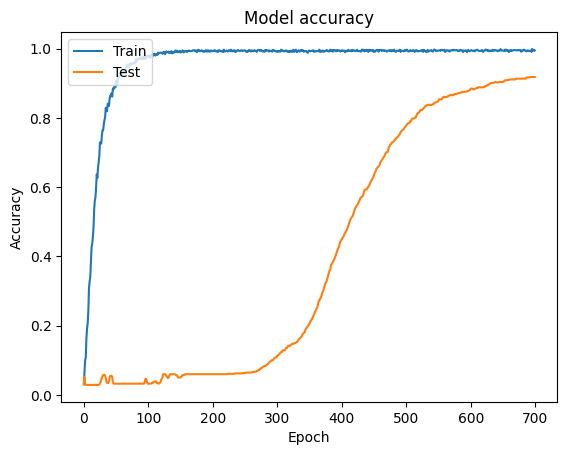

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
DD_Net.save_weights('weights/fine_heavy.h5')

In [15]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [16]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [17]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9178571428571428


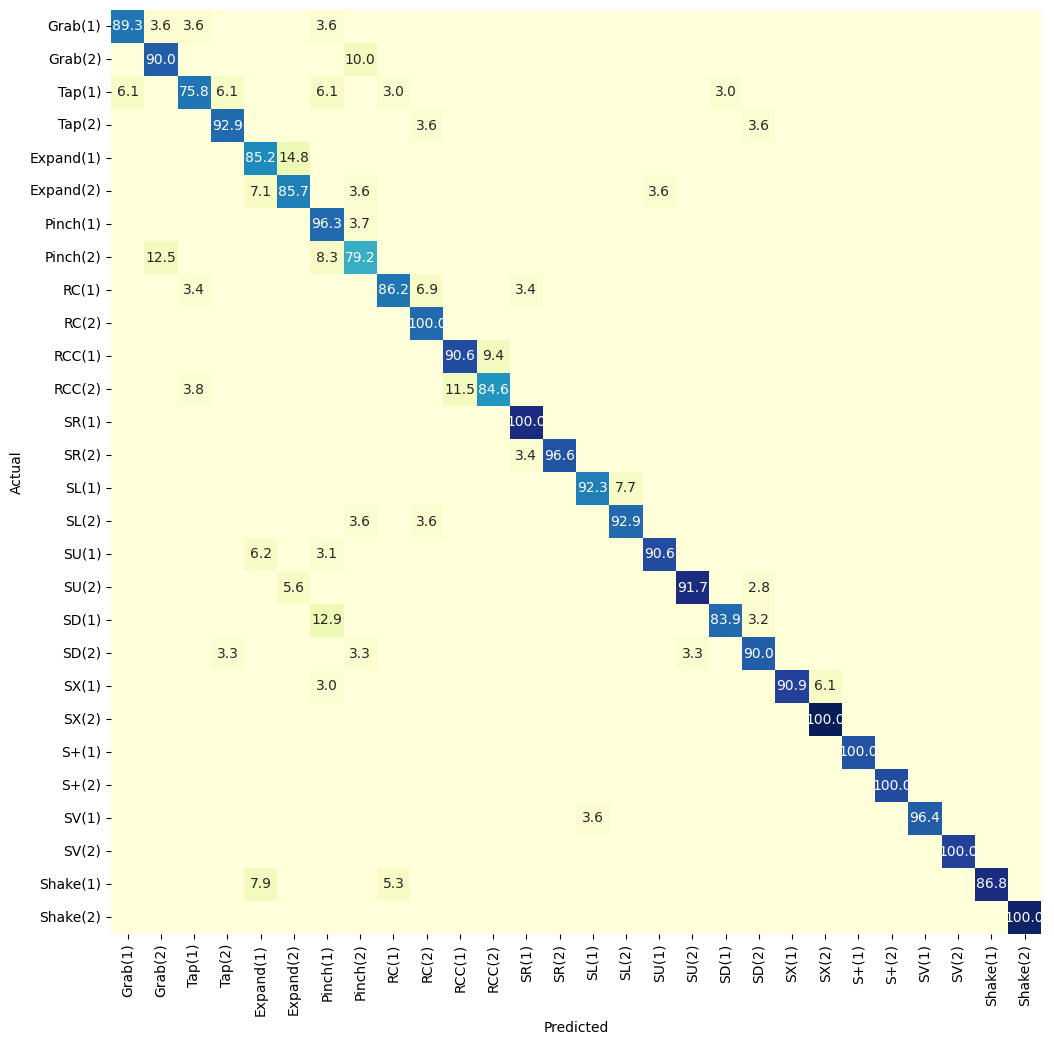

In [18]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_1.png', labels, ymap=None, figsize=(12,12))

## Training with frame_sampling

In [19]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [20]:
epochs = 20 #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
#         print(type(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 123.42it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0723 - accuracy: 0.9913 - val_loss: 0.3313 - val_accuracy: 0.9179
epoch1


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 123.80it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 135us/step - loss: 0.0737 - accuracy: 0.9934 - val_loss: 0.3308 - val_accuracy: 0.9167
epoch2


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.66it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 143us/step - loss: 0.0745 - accuracy: 0.9913 - val_loss: 0.3303 - val_accuracy: 0.9167
epoch3


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.85it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 141us/step - loss: 0.0841 - accuracy: 0.9888 - val_loss: 0.3300 - val_accuracy: 0.9179
epoch4


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.27it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 147us/step - loss: 0.0779 - accuracy: 0.9918 - val_loss: 0.3299 - val_accuracy: 0.9179
epoch5


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.37it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 143us/step - loss: 0.0782 - accuracy: 0.9934 - val_loss: 0.3295 - val_accuracy: 0.9179
epoch6


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.86it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 141us/step - loss: 0.0751 - accuracy: 0.9929 - val_loss: 0.3290 - val_accuracy: 0.9179
epoch7


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.96it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0792 - accuracy: 0.9923 - val_loss: 0.3288 - val_accuracy: 0.9190
epoch8


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 122.14it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0843 - accuracy: 0.9908 - val_loss: 0.3288 - val_accuracy: 0.9190
epoch9


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.29it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 141us/step - loss: 0.0733 - accuracy: 0.9944 - val_loss: 0.3289 - val_accuracy: 0.9190
epoch10


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.48it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 139us/step - loss: 0.0807 - accuracy: 0.9883 - val_loss: 0.3291 - val_accuracy: 0.9202
epoch11


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.15it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 147us/step - loss: 0.0702 - accuracy: 0.9934 - val_loss: 0.3291 - val_accuracy: 0.9202
epoch12


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.07it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 143us/step - loss: 0.0717 - accuracy: 0.9934 - val_loss: 0.3292 - val_accuracy: 0.9202
epoch13


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.35it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 133us/step - loss: 0.0738 - accuracy: 0.9918 - val_loss: 0.3293 - val_accuracy: 0.9202
epoch14


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 122.64it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 135us/step - loss: 0.0743 - accuracy: 0.9929 - val_loss: 0.3294 - val_accuracy: 0.9190
epoch15


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.57it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 143us/step - loss: 0.0780 - accuracy: 0.9918 - val_loss: 0.3296 - val_accuracy: 0.9202
epoch16


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.14it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 134us/step - loss: 0.0767 - accuracy: 0.9903 - val_loss: 0.3296 - val_accuracy: 0.9214
epoch17


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.67it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0705 - accuracy: 0.9944 - val_loss: 0.3294 - val_accuracy: 0.9226
epoch18


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.96it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 134us/step - loss: 0.0803 - accuracy: 0.9918 - val_loss: 0.3291 - val_accuracy: 0.9226
epoch19


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.35it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0712 - accuracy: 0.9939 - val_loss: 0.3286 - val_accuracy: 0.9238


# Plot confusion matrix

In [21]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [22]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [23]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9238095238095239


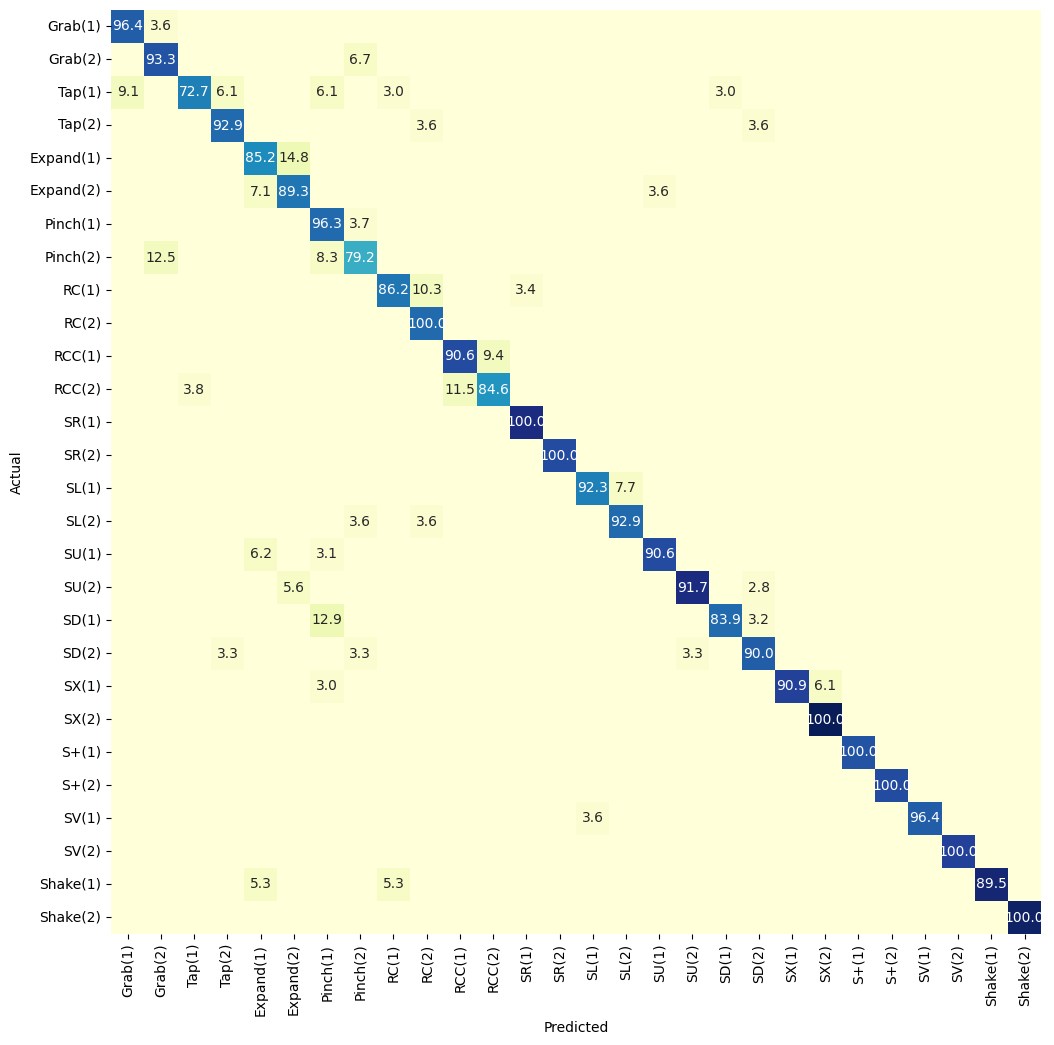

In [24]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_2.png', labels, ymap=None, figsize=(12,12))

# Policy gradient for frame selection  -------train

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



gamma = 0.7



class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(8448,3))  #20 3960  #10 1980 #30 8448
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #Variable进行自动微分；
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 25 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = 7*(np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1]))## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num = 1
    max_steps = 20  
    all_rewards = []
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
            Action=[]
            if len(oridata[v])>=32:
                rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 22, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1).reshape([32,22,3])
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

                M = get_CG(q,C)  
                q = q.reshape(1,32,22,3)
                M = M.reshape(1,32,231)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1   
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)
        print(x_tr)   
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))


oridata = []


for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,22,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    

labels = [int(Train['fine_label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|████████████████████████████████████| 1960/1960 [00:00<00:00, 41205.34it/s]


In [27]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

  5%|█▉                                       | 95/1960 [01:03<20:52,  1.49it/s]


 10%|███▉                                    | 192/1960 [02:07<19:18,  1.53it/s]


 15%|█████▉                                  | 289/1960 [03:12<18:27,  1.51it/s]


 20%|███████▉                                | 386/1960 [04:16<17:22,  1.51it/s]


 25%|█████████▊                              | 483/1960 [05:20<16:06,  1.53it/s]


 30%|███████████▊                            | 580/1960 [06:28<17:13,  1.34it/s]


 35%|█████████████▊                          | 677/1960 [07:39<15:56,  1.34it/s]


 39%|███████████████▊                        | 774/1960 [08:51<14:35,  1.35it/s]


 44%|█████████████████▊                      | 871/1960 [10:00<11:55,  1.52it/s]


 49%|███████████████████▊                    | 968/1960 [11:05<11:00,  1.50it/s]


 54%|█████████████████████▏                 | 1065/1960 [12:09<10:20,  1.44it/s]


 59%|███████████████████████                | 1162/1960 [13:13<08:35,  1.55it/s]


 64%|█████████████████████████              | 1259/1960 [14:17<07:44,  1.51it/s]


 69%|██████████████████████████▉            | 1356/1960 [15:21<06:41,  1.50it/s]


 74%|████████████████████████████▉          | 1453/1960 [16:26<05:34,  1.52it/s]


 79%|██████████████████████████████▊        | 1550/1960 [17:31<05:00,  1.37it/s]


 84%|████████████████████████████████▊      | 1647/1960 [18:44<03:53,  1.34it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [19:57<02:42,  1.33it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [21:02<01:24,  1.41it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [22:10<00:14,  1.52it/s]


100%|███████████████████████████████████████████| 1/1 [22:24<00:00, 1344.79s/it]

tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3541, -0.3207,  0.4625],
          [ 0.3312, -0.3412,  0.4597],
          ...,
          [ 0.3985, -0.2904,  0.4601],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3538, -0.3207,  0.4611],
          [ 0.3312, -0.3412,  0.4590],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         ...,

         [[ 0.2730, -0.2446,  0.3057],
          [ 0.2552, -0.1916,  0.2921],
          [ 0.2421, -0.2243,  0.2908],
          ...,
          [ 0.3004, -0.1702,  0.2906],
          [ 0.2907, -0.1831,  0.2805],
          [ 0.2882, -0

In [28]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/media/l/data/HRC/HRC_intention_recognition/code/DD-Net-master/SHREC/images/RLsherc_14_reward_fine.png")
#plt.grid()

[-96.125]


In [29]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 125.44it/s]


In [30]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.1193 - accuracy: 0.9781 - val_loss: 0.5908 - val_accuracy: 0.8524
Epoch 2/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.2082 - accuracy: 0.9531 - val_loss: 0.3799 - val_accuracy: 0.9107
Epoch 3/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.1813 - accuracy: 0.9597 - val_loss: 0.3736 - val_accuracy: 0.9000
Epoch 4/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.1806 - accuracy: 0.9648 - val_loss: 0.4319 - val_accuracy: 0.8786
Epoch 5/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.1349 - accuracy: 0.9760 - val_loss: 0.4019 - val_accuracy: 0.8964
Epoch 6/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.1333 - accuracy: 0.9724 - val_loss: 0.3835 - val_accuracy: 0.9071
Epoch 7/600
1960/1960 [==============================] - 0s 132us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0448 - accuracy: 0.9969 - val_loss: 0.3749 - val_accuracy: 0.9274
Epoch 58/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0465 - accuracy: 0.9944 - val_loss: 0.3719 - val_accuracy: 0.9262
Epoch 59/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0538 - accuracy: 0.9944 - val_loss: 0.3693 - val_accuracy: 0.9274
Epoch 60/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0453 - accuracy: 0.9959 - val_loss: 0.3665 - val_accuracy: 0.9274
Epoch 61/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0481 - accuracy: 0.9944 - val_loss: 0.3649 - val_accuracy: 0.9274
Epoch 62/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0424 - accuracy: 0.9944 - val_loss: 0.3631 - val_accuracy: 0.9274
Epoch 63/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0478 - accuracy: 0.9949 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0445 - accuracy: 0.9954 - val_loss: 0.3401 - val_accuracy: 0.9286
Epoch 114/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0425 - accuracy: 0.9964 - val_loss: 0.3400 - val_accuracy: 0.9286
Epoch 115/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0437 - accuracy: 0.9959 - val_loss: 0.3399 - val_accuracy: 0.9286
Epoch 116/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0410 - accuracy: 0.9974 - val_loss: 0.3399 - val_accuracy: 0.9286
Epoch 117/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0373 - accuracy: 0.9974 - val_loss: 0.3399 - val_accuracy: 0.9286
Epoch 118/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0355 - accuracy: 0.9980 - val_loss: 0.3398 - val_accuracy: 0.9286
Epoch 119/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0393 - accuracy: 0.9964

Epoch 168/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0360 - accuracy: 0.9990 - val_loss: 0.3380 - val_accuracy: 0.9274
Epoch 169/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0385 - accuracy: 0.9969 - val_loss: 0.3381 - val_accuracy: 0.9274
Epoch 170/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0397 - accuracy: 0.9974 - val_loss: 0.3380 - val_accuracy: 0.9274
Epoch 171/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0409 - accuracy: 0.9964 - val_loss: 0.3380 - val_accuracy: 0.9274
Epoch 172/600
1960/1960 [==============================] - 0s 151us/step - loss: 0.0354 - accuracy: 0.9974 - val_loss: 0.3380 - val_accuracy: 0.9274
Epoch 173/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0396 - accuracy: 0.9959 - val_loss: 0.3381 - val_accuracy: 0.9274
Epoch 174/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0428 - accuracy: 0.9964

Epoch 223/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0419 - accuracy: 0.9964 - val_loss: 0.3390 - val_accuracy: 0.9286
Epoch 224/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0404 - accuracy: 0.9949 - val_loss: 0.3390 - val_accuracy: 0.9286
Epoch 225/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0374 - accuracy: 0.9964 - val_loss: 0.3391 - val_accuracy: 0.9286
Epoch 226/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0422 - accuracy: 0.9944 - val_loss: 0.3391 - val_accuracy: 0.9286
Epoch 227/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0404 - accuracy: 0.9949 - val_loss: 0.3391 - val_accuracy: 0.9286
Epoch 228/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0378 - accuracy: 0.9964 - val_loss: 0.3392 - val_accuracy: 0.9286
Epoch 229/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0375 - accuracy: 0.9974

Epoch 278/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0393 - accuracy: 0.9969 - val_loss: 0.3413 - val_accuracy: 0.9286
Epoch 279/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0378 - accuracy: 0.9954 - val_loss: 0.3414 - val_accuracy: 0.9286
Epoch 280/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0346 - accuracy: 0.9980 - val_loss: 0.3414 - val_accuracy: 0.9286
Epoch 281/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0420 - accuracy: 0.9964 - val_loss: 0.3415 - val_accuracy: 0.9286
Epoch 282/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0344 - accuracy: 0.9974 - val_loss: 0.3415 - val_accuracy: 0.9286
Epoch 283/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0390 - accuracy: 0.9974 - val_loss: 0.3415 - val_accuracy: 0.9286
Epoch 284/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0343 - accuracy: 0.9959

Epoch 333/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0408 - accuracy: 0.9985 - val_loss: 0.3445 - val_accuracy: 0.9298
Epoch 334/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0401 - accuracy: 0.9944 - val_loss: 0.3444 - val_accuracy: 0.9298
Epoch 335/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0334 - accuracy: 0.9980 - val_loss: 0.3444 - val_accuracy: 0.9298
Epoch 336/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0332 - accuracy: 0.9964 - val_loss: 0.3443 - val_accuracy: 0.9298
Epoch 337/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0404 - accuracy: 0.9980 - val_loss: 0.3443 - val_accuracy: 0.9298
Epoch 338/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0402 - accuracy: 0.9969 - val_loss: 0.3441 - val_accuracy: 0.9298
Epoch 339/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0387 - accuracy: 0.9964

Epoch 388/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0339 - accuracy: 0.9985 - val_loss: 0.3435 - val_accuracy: 0.9310
Epoch 389/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0373 - accuracy: 0.9954 - val_loss: 0.3435 - val_accuracy: 0.9310
Epoch 390/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0377 - accuracy: 0.9974 - val_loss: 0.3435 - val_accuracy: 0.9310
Epoch 391/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0392 - accuracy: 0.9954 - val_loss: 0.3435 - val_accuracy: 0.9310
Epoch 392/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0317 - accuracy: 0.9990 - val_loss: 0.3434 - val_accuracy: 0.9310
Epoch 393/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0419 - accuracy: 0.9923 - val_loss: 0.3434 - val_accuracy: 0.9310
Epoch 394/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0369 - accuracy: 0.9969

Epoch 443/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0332 - accuracy: 0.9980 - val_loss: 0.3395 - val_accuracy: 0.9321
Epoch 444/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0380 - accuracy: 0.9980 - val_loss: 0.3394 - val_accuracy: 0.9321
Epoch 445/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0367 - accuracy: 0.9954 - val_loss: 0.3393 - val_accuracy: 0.9321
Epoch 446/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0386 - accuracy: 0.9964 - val_loss: 0.3394 - val_accuracy: 0.9321
Epoch 447/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0385 - accuracy: 0.9949 - val_loss: 0.3394 - val_accuracy: 0.9321
Epoch 448/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0370 - accuracy: 0.9995 - val_loss: 0.3394 - val_accuracy: 0.9321
Epoch 449/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0396 - accuracy: 0.9954

Epoch 498/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0374 - accuracy: 0.9954 - val_loss: 0.3412 - val_accuracy: 0.9310
Epoch 499/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0361 - accuracy: 0.9959 - val_loss: 0.3412 - val_accuracy: 0.9310
Epoch 500/600
1960/1960 [==============================] - 0s 152us/step - loss: 0.0348 - accuracy: 0.9959 - val_loss: 0.3412 - val_accuracy: 0.9310
Epoch 501/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0354 - accuracy: 0.9974 - val_loss: 0.3412 - val_accuracy: 0.9310
Epoch 502/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0381 - accuracy: 0.9969 - val_loss: 0.3413 - val_accuracy: 0.9310
Epoch 503/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0346 - accuracy: 0.9980 - val_loss: 0.3413 - val_accuracy: 0.9310
Epoch 504/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0403 - accuracy: 0.9964

Epoch 553/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0347 - accuracy: 0.9969 - val_loss: 0.3429 - val_accuracy: 0.9321
Epoch 554/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0363 - accuracy: 0.9964 - val_loss: 0.3428 - val_accuracy: 0.9321
Epoch 555/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0343 - accuracy: 0.9974 - val_loss: 0.3427 - val_accuracy: 0.9321
Epoch 556/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0361 - accuracy: 0.9980 - val_loss: 0.3426 - val_accuracy: 0.9321
Epoch 557/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0383 - accuracy: 0.9964 - val_loss: 0.3425 - val_accuracy: 0.9321
Epoch 558/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0349 - accuracy: 0.9985 - val_loss: 0.3426 - val_accuracy: 0.9321
Epoch 559/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0328 - accuracy: 0.9969

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels_train = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_train[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels_train[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.930952380952381


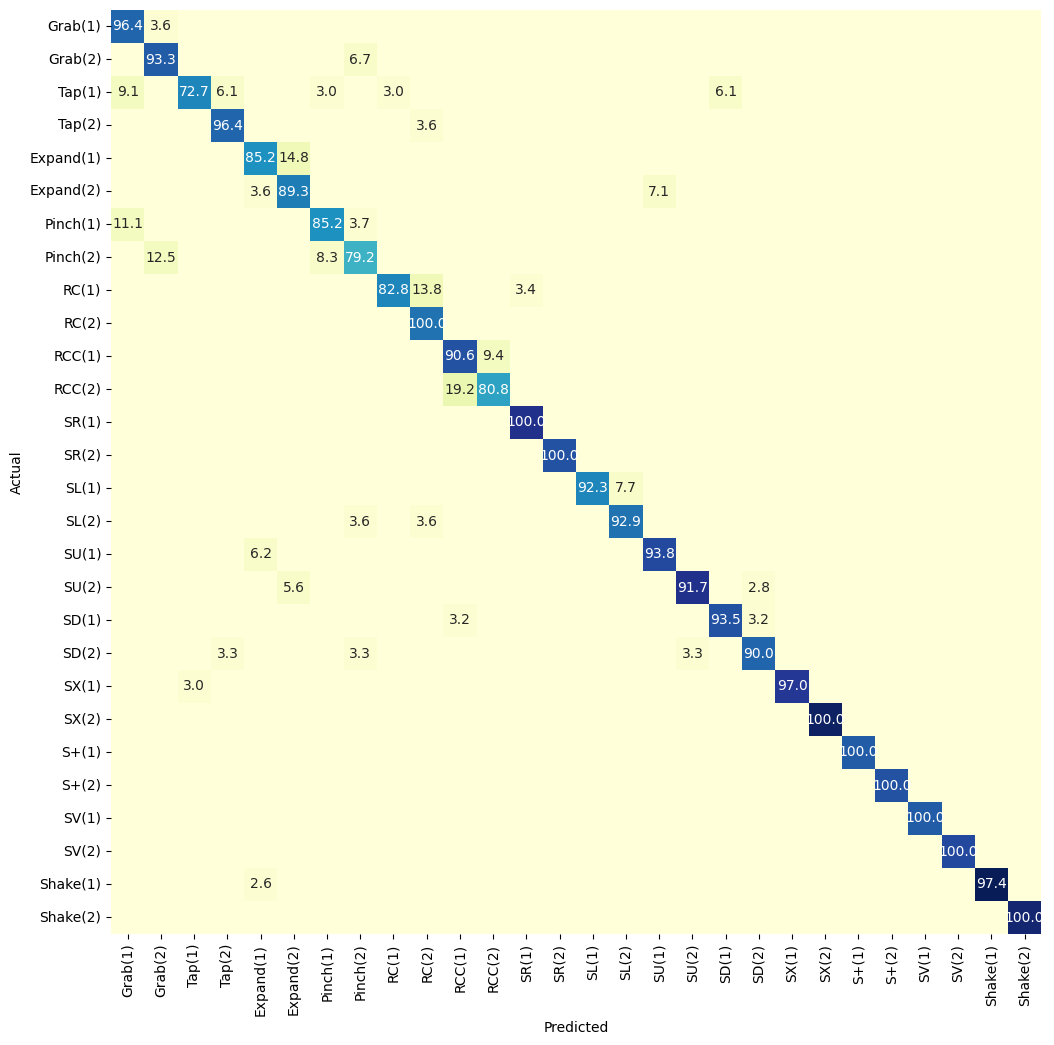

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_3.png', labels_train, ymap=None, figsize=(12,12))

### epoch 2 

In [35]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

  5%|█▉                                       | 95/1960 [01:11<23:51,  1.30it/s]


 10%|███▉                                    | 192/1960 [02:25<22:12,  1.33it/s]


 15%|█████▉                                  | 289/1960 [03:37<21:14,  1.31it/s]


 20%|███████▉                                | 386/1960 [04:50<19:50,  1.32it/s]


 25%|█████████▊                              | 483/1960 [06:03<19:02,  1.29it/s]


 30%|███████████▊                            | 580/1960 [07:17<17:18,  1.33it/s]


 35%|█████████████▊                          | 677/1960 [08:30<16:25,  1.30it/s]


 39%|███████████████▊                        | 774/1960 [09:43<14:52,  1.33it/s]


 44%|█████████████████▊                      | 871/1960 [10:57<13:34,  1.34it/s]


 49%|███████████████████▊                    | 968/1960 [12:10<12:20,  1.34it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:24<11:28,  1.30it/s]


 59%|███████████████████████                | 1162/1960 [14:37<10:34,  1.26it/s]


 64%|█████████████████████████              | 1259/1960 [15:51<09:00,  1.30it/s]


 69%|██████████████████████████▉            | 1356/1960 [17:05<07:39,  1.32it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:18<06:18,  1.34it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:31<05:10,  1.32it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:44<03:45,  1.39it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:57<02:42,  1.33it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [23:11<01:31,  1.30it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:24<00:16,  1.32it/s]


100%|███████████████████████████████████████████| 1/1 [24:41<00:00, 1481.65s/it]

tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3541, -0.3207,  0.4625],
          [ 0.3312, -0.3412,  0.4597],
          ...,
          [ 0.3985, -0.2904,  0.4601],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3538, -0.3207,  0.4611],
          [ 0.3312, -0.3412,  0.4590],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         ...,

         [[ 0.2730, -0.2446,  0.3057],
          [ 0.2552, -0.1916,  0.2921],
          [ 0.2421, -0.2243,  0.2908],
          ...,
          [ 0.3004, -0.1702,  0.2906],
          [ 0.2907, -0.1831,  0.2805],
          [ 0.2882, -0

In [36]:
print(all_rewards)

[-61.25]


In [39]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 125.88it/s]


In [40]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0319 - accuracy: 0.9974 - val_loss: 0.5101 - val_accuracy: 0.8952
Epoch 2/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0835 - accuracy: 0.9827 - val_loss: 0.5544 - val_accuracy: 0.9012
Epoch 3/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0663 - accuracy: 0.9862 - val_loss: 0.7400 - val_accuracy: 0.8798
Epoch 4/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0809 - accuracy: 0.9821 - val_loss: 0.5192 - val_accuracy: 0.8988
Epoch 5/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0808 - accuracy: 0.9872 - val_loss: 0.4328 - val_accuracy: 0.9190
Epoch 6/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0850 - accuracy: 0.9796 - val_loss: 0.3765 - val_accuracy: 0.9238
Epoch 7/600
1960/1960 [==============================] - 0s 122us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0285 - accuracy: 0.9974 - val_loss: 0.3827 - val_accuracy: 0.9333
Epoch 58/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0274 - accuracy: 0.9969 - val_loss: 0.3825 - val_accuracy: 0.9333
Epoch 59/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0317 - accuracy: 0.9954 - val_loss: 0.3824 - val_accuracy: 0.9333
Epoch 60/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0300 - accuracy: 0.9964 - val_loss: 0.3823 - val_accuracy: 0.9333
Epoch 61/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0279 - accuracy: 0.9985 - val_loss: 0.3823 - val_accuracy: 0.9333
Epoch 62/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0297 - accuracy: 0.9969 - val_loss: 0.3824 - val_accuracy: 0.9333
Epoch 63/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0287 - accuracy: 0.9990 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0320 - accuracy: 0.9959 - val_loss: 0.3737 - val_accuracy: 0.9333
Epoch 114/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0313 - accuracy: 0.9964 - val_loss: 0.3734 - val_accuracy: 0.9333
Epoch 115/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0289 - accuracy: 0.9985 - val_loss: 0.3732 - val_accuracy: 0.9333
Epoch 116/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0294 - accuracy: 0.9969 - val_loss: 0.3730 - val_accuracy: 0.9333
Epoch 117/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0324 - accuracy: 0.9954 - val_loss: 0.3728 - val_accuracy: 0.9345
Epoch 118/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0288 - accuracy: 0.9985 - val_loss: 0.3726 - val_accuracy: 0.9345
Epoch 119/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0288 - accuracy: 0.9969

Epoch 168/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0269 - accuracy: 0.9980 - val_loss: 0.3688 - val_accuracy: 0.9333
Epoch 169/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0282 - accuracy: 0.9985 - val_loss: 0.3688 - val_accuracy: 0.9333
Epoch 170/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0254 - accuracy: 0.9974 - val_loss: 0.3687 - val_accuracy: 0.9333
Epoch 171/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0276 - accuracy: 0.9959 - val_loss: 0.3687 - val_accuracy: 0.9333
Epoch 172/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0325 - accuracy: 0.9959 - val_loss: 0.3686 - val_accuracy: 0.9333
Epoch 173/600
1960/1960 [==============================] - 0s 125us/step - loss: 0.0289 - accuracy: 0.9974 - val_loss: 0.3685 - val_accuracy: 0.9333
Epoch 174/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0316 - accuracy: 0.9959

Epoch 223/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0281 - accuracy: 0.9969 - val_loss: 0.3639 - val_accuracy: 0.9333
Epoch 224/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0265 - accuracy: 0.9985 - val_loss: 0.3640 - val_accuracy: 0.9333
Epoch 225/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0279 - accuracy: 0.9980 - val_loss: 0.3641 - val_accuracy: 0.9333
Epoch 226/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0272 - accuracy: 0.9964 - val_loss: 0.3642 - val_accuracy: 0.9333
Epoch 227/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0281 - accuracy: 0.9985 - val_loss: 0.3642 - val_accuracy: 0.9333
Epoch 228/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0294 - accuracy: 0.9964 - val_loss: 0.3643 - val_accuracy: 0.9333
Epoch 229/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0313 - accuracy: 0.9969

Epoch 278/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0278 - accuracy: 0.9980 - val_loss: 0.3651 - val_accuracy: 0.9321
Epoch 279/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0272 - accuracy: 0.9969 - val_loss: 0.3651 - val_accuracy: 0.9321
Epoch 280/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0287 - accuracy: 0.9974 - val_loss: 0.3650 - val_accuracy: 0.9321
Epoch 281/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0287 - accuracy: 0.9974 - val_loss: 0.3649 - val_accuracy: 0.9321
Epoch 282/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0293 - accuracy: 0.9964 - val_loss: 0.3648 - val_accuracy: 0.9321
Epoch 283/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0299 - accuracy: 0.9964 - val_loss: 0.3648 - val_accuracy: 0.9321
Epoch 284/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0256 - accuracy: 0.9990

Epoch 333/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0270 - accuracy: 0.9974 - val_loss: 0.3627 - val_accuracy: 0.9345
Epoch 334/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0280 - accuracy: 0.9995 - val_loss: 0.3628 - val_accuracy: 0.9333
Epoch 335/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0298 - accuracy: 0.9964 - val_loss: 0.3629 - val_accuracy: 0.9333
Epoch 336/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0262 - accuracy: 0.9985 - val_loss: 0.3630 - val_accuracy: 0.9333
Epoch 337/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0286 - accuracy: 0.9974 - val_loss: 0.3631 - val_accuracy: 0.9333
Epoch 338/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0303 - accuracy: 0.9974 - val_loss: 0.3631 - val_accuracy: 0.9333
Epoch 339/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0300 - accuracy: 0.9974

Epoch 388/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0252 - accuracy: 0.9985 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 389/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0293 - accuracy: 0.9969 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 390/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0262 - accuracy: 0.9985 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 391/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0289 - accuracy: 0.9969 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 392/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0277 - accuracy: 0.9990 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 393/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0269 - accuracy: 0.9974 - val_loss: 0.3666 - val_accuracy: 0.9310
Epoch 394/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0243 - accuracy: 0.9985

Epoch 443/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0239 - accuracy: 0.9990 - val_loss: 0.3703 - val_accuracy: 0.9298
Epoch 444/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0249 - accuracy: 0.9990 - val_loss: 0.3702 - val_accuracy: 0.9298
Epoch 445/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0261 - accuracy: 0.9995 - val_loss: 0.3703 - val_accuracy: 0.9298
Epoch 446/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0244 - accuracy: 0.9980 - val_loss: 0.3703 - val_accuracy: 0.9298
Epoch 447/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0257 - accuracy: 0.9980 - val_loss: 0.3704 - val_accuracy: 0.9298
Epoch 448/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0239 - accuracy: 0.9985 - val_loss: 0.3706 - val_accuracy: 0.9298
Epoch 449/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0267 - accuracy: 0.9964

Epoch 498/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0298 - accuracy: 0.9974 - val_loss: 0.3715 - val_accuracy: 0.9286
Epoch 499/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.3713 - val_accuracy: 0.9286
Epoch 500/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0272 - accuracy: 0.9974 - val_loss: 0.3712 - val_accuracy: 0.9286
Epoch 501/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0267 - accuracy: 0.9980 - val_loss: 0.3711 - val_accuracy: 0.9286
Epoch 502/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0247 - accuracy: 0.9985 - val_loss: 0.3710 - val_accuracy: 0.9286
Epoch 503/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0256 - accuracy: 0.9969 - val_loss: 0.3709 - val_accuracy: 0.9286
Epoch 504/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0283 - accuracy: 0.9969

Epoch 553/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0280 - accuracy: 0.9969 - val_loss: 0.3688 - val_accuracy: 0.9274
Epoch 554/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0248 - accuracy: 0.9980 - val_loss: 0.3687 - val_accuracy: 0.9274
Epoch 555/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0244 - accuracy: 0.9969 - val_loss: 0.3686 - val_accuracy: 0.9274
Epoch 556/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0268 - accuracy: 0.9990 - val_loss: 0.3685 - val_accuracy: 0.9274
Epoch 557/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0286 - accuracy: 0.9969 - val_loss: 0.3685 - val_accuracy: 0.9274
Epoch 558/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0247 - accuracy: 0.9974 - val_loss: 0.3685 - val_accuracy: 0.9274
Epoch 559/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0242 - accuracy: 0.9990

In [41]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9297619047619048


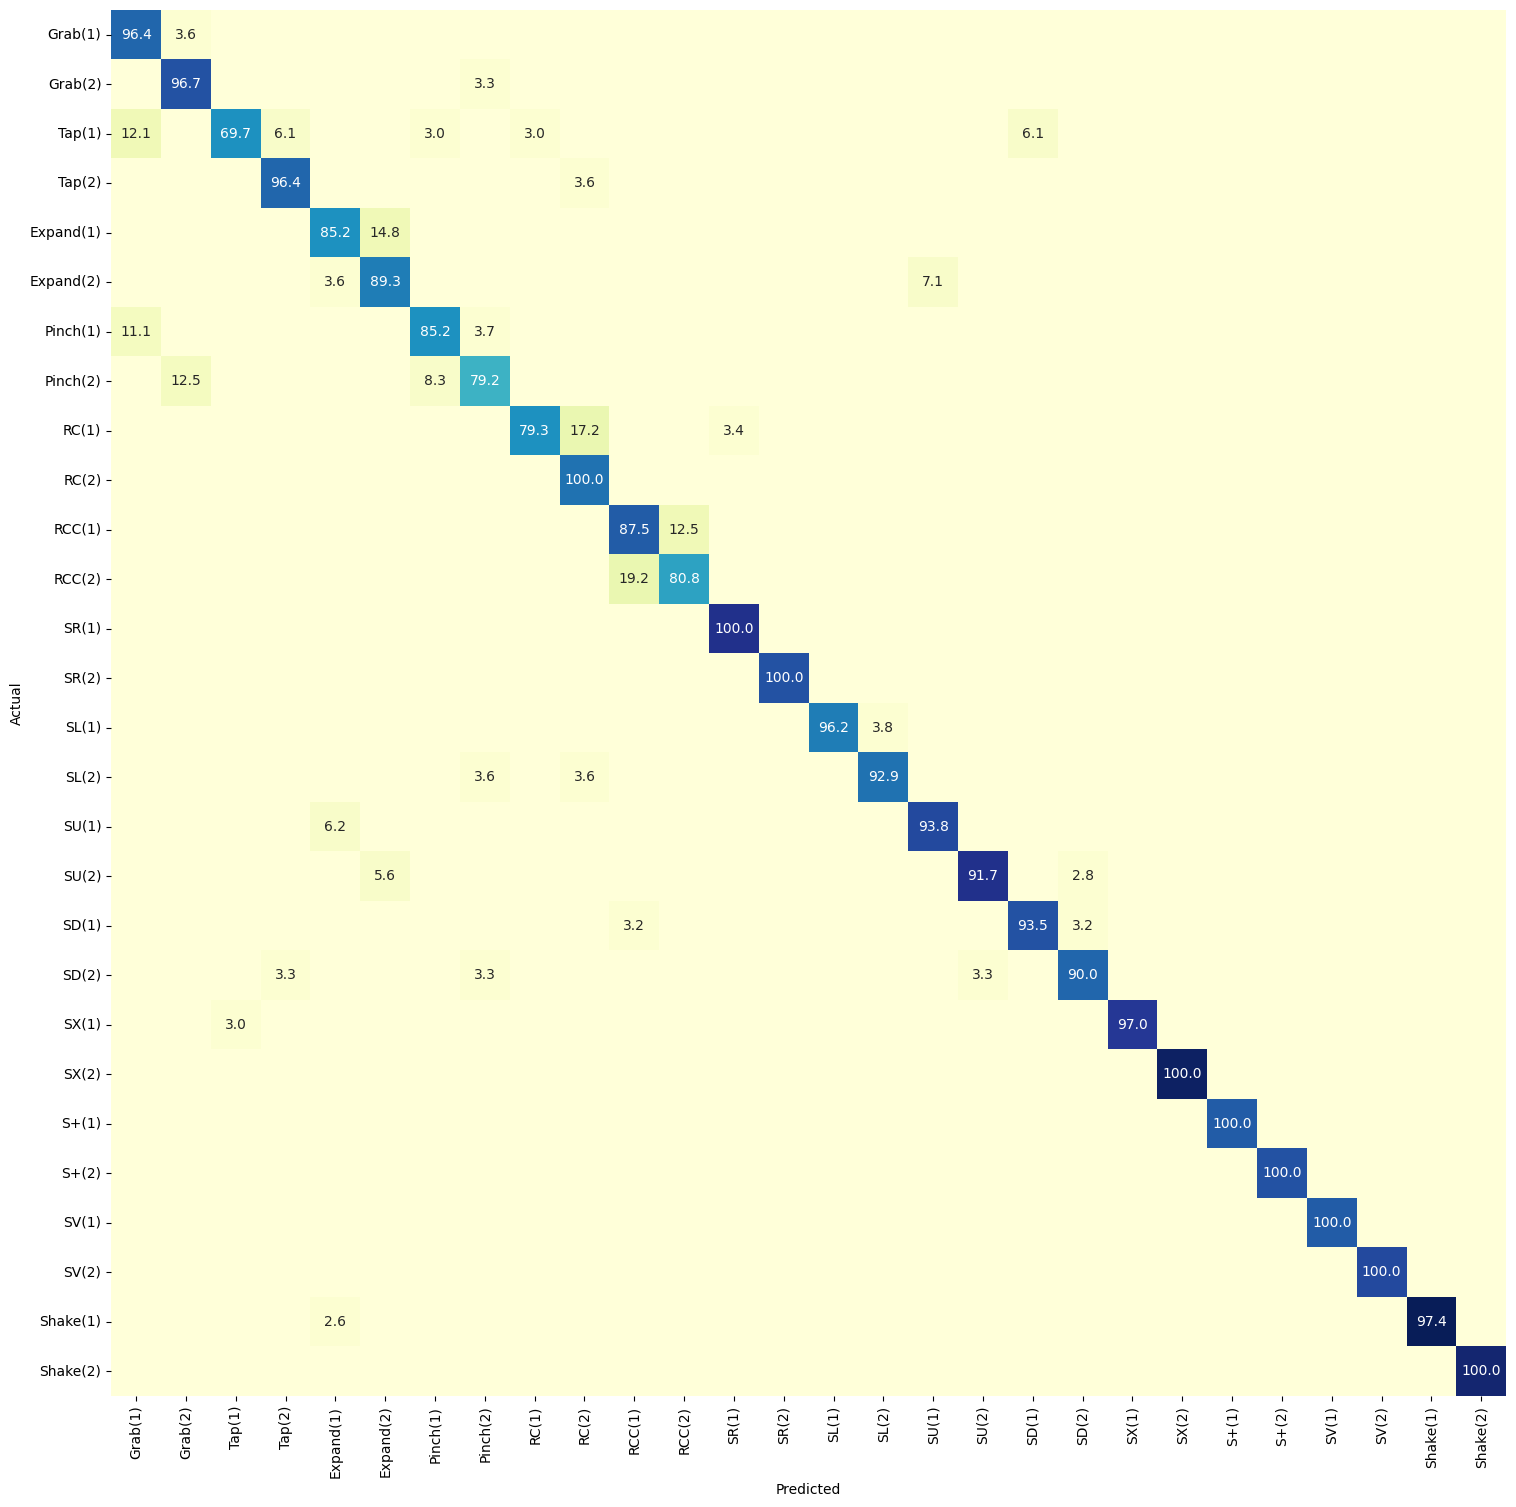

In [42]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_5.png', labels, ymap=None, figsize=(18,18))

### epoch 3

In [43]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:10<20:58,  1.48it/s]


 10%|███▉                                    | 192/1960 [02:18<22:43,  1.30it/s]


 15%|█████▉                                  | 289/1960 [03:31<21:02,  1.32it/s]


 20%|███████▉                                | 386/1960 [04:45<19:35,  1.34it/s]


 25%|█████████▊                              | 483/1960 [05:58<18:51,  1.31it/s]


 30%|███████████▊                            | 580/1960 [07:11<17:22,  1.32it/s]


 35%|█████████████▊                          | 677/1960 [08:25<16:02,  1.33it/s]


 39%|███████████████▊                        | 774/1960 [09:37<14:46,  1.34it/s]


 44%|█████████████████▊                      | 871/1960 [10:49<13:53,  1.31it/s]


 49%|███████████████████▊                    | 968/1960 [12:02<12:16,  1.35it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:15<11:07,  1.34it/s]


 59%|███████████████████████                | 1162/1960 [14:29<09:55,  1.34it/s]


 64%|█████████████████████████              | 1259/1960 [15:43<08:56,  1.31it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:56<07:39,  1.31it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:09<06:21,  1.33it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:22<05:09,  1.32it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:36<03:57,  1.32it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:49<02:43,  1.32it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [23:03<01:29,  1.33it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:15<00:16,  1.32it/s]


100%|███████████████████████████████████████████| 1/1 [24:32<00:00, 1472.53s/it]


tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3541, -0.3207,  0.4625],
          [ 0.3312, -0.3412,  0.4597],
          ...,
          [ 0.3985, -0.2904,  0.4601],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3538, -0.3207,  0.4611],
          [ 0.3312, -0.3412,  0.4590],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         ...,

         [[ 0.2730, -0.2446,  0.3057],
          [ 0.2552, -0.1916,  0.2921],
          [ 0.2421, -0.2243,  0.2908],
          ...,
          [ 0.3004, -0.1702,  0.2906],
          [ 0.2907, -0.1831,  0.2805],
          [ 0.2882, -0

100%|██████████████████████████████████████| 1960/1960 [00:14<00:00, 131.50it/s]


In [44]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0243 - accuracy: 0.9985 - val_loss: 0.6175 - val_accuracy: 0.8929
Epoch 2/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.1807 - accuracy: 0.9658 - val_loss: 0.5200 - val_accuracy: 0.8893
Epoch 3/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0824 - accuracy: 0.9827 - val_loss: 0.5734 - val_accuracy: 0.8810
Epoch 4/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0989 - accuracy: 0.9806 - val_loss: 0.4921 - val_accuracy: 0.9036
Epoch 5/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0816 - accuracy: 0.9883 - val_loss: 0.4819 - val_accuracy: 0.9119
Epoch 6/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0914 - accuracy: 0.9781 - val_loss: 0.5223 - val_accuracy: 0.8905
Epoch 7/600
1960/1960 [==============================] - 0s 133us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0271 - accuracy: 0.9974 - val_loss: 0.3929 - val_accuracy: 0.9274
Epoch 58/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0221 - accuracy: 0.9995 - val_loss: 0.3915 - val_accuracy: 0.9274
Epoch 59/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0234 - accuracy: 0.9985 - val_loss: 0.3906 - val_accuracy: 0.9274
Epoch 60/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0271 - accuracy: 0.9964 - val_loss: 0.3903 - val_accuracy: 0.9274
Epoch 61/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0225 - accuracy: 0.9980 - val_loss: 0.3900 - val_accuracy: 0.9274
Epoch 62/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0256 - accuracy: 0.9964 - val_loss: 0.3899 - val_accuracy: 0.9274
Epoch 63/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0246 - accuracy: 0.9985 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0252 - accuracy: 0.9954 - val_loss: 0.3854 - val_accuracy: 0.9298
Epoch 114/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0223 - accuracy: 0.9974 - val_loss: 0.3852 - val_accuracy: 0.9298
Epoch 115/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0261 - accuracy: 0.9964 - val_loss: 0.3849 - val_accuracy: 0.9298
Epoch 116/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0213 - accuracy: 0.9990 - val_loss: 0.3846 - val_accuracy: 0.9298
Epoch 117/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0257 - accuracy: 0.9959 - val_loss: 0.3844 - val_accuracy: 0.9298
Epoch 118/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0226 - accuracy: 0.9985 - val_loss: 0.3842 - val_accuracy: 0.9298
Epoch 119/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0204 - accuracy: 0.9985

Epoch 168/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0227 - accuracy: 0.9969 - val_loss: 0.3780 - val_accuracy: 0.9321
Epoch 169/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0215 - accuracy: 0.9995 - val_loss: 0.3779 - val_accuracy: 0.9321
Epoch 170/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0219 - accuracy: 0.9980 - val_loss: 0.3778 - val_accuracy: 0.9321
Epoch 171/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0205 - accuracy: 0.9985 - val_loss: 0.3775 - val_accuracy: 0.9321
Epoch 172/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0253 - accuracy: 0.9980 - val_loss: 0.3773 - val_accuracy: 0.9321
Epoch 173/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0197 - accuracy: 0.9995 - val_loss: 0.3772 - val_accuracy: 0.9321
Epoch 174/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0290 - accuracy: 0.9959

Epoch 223/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0223 - accuracy: 0.9980 - val_loss: 0.3767 - val_accuracy: 0.9298
Epoch 224/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0238 - accuracy: 0.9974 - val_loss: 0.3766 - val_accuracy: 0.9298
Epoch 225/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0239 - accuracy: 0.9985 - val_loss: 0.3767 - val_accuracy: 0.9298
Epoch 226/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0235 - accuracy: 0.9969 - val_loss: 0.3767 - val_accuracy: 0.9298
Epoch 227/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0197 - accuracy: 0.9995 - val_loss: 0.3767 - val_accuracy: 0.9298
Epoch 228/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0201 - accuracy: 0.9980 - val_loss: 0.3768 - val_accuracy: 0.9298
Epoch 229/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0207 - accuracy: 0.9980

Epoch 278/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0201 - accuracy: 0.9990 - val_loss: 0.3764 - val_accuracy: 0.9286
Epoch 279/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0211 - accuracy: 0.9990 - val_loss: 0.3766 - val_accuracy: 0.9286
Epoch 280/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0193 - accuracy: 0.9990 - val_loss: 0.3767 - val_accuracy: 0.9286
Epoch 281/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0177 - accuracy: 0.9985 - val_loss: 0.3768 - val_accuracy: 0.9286
Epoch 282/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0257 - accuracy: 0.9954 - val_loss: 0.3768 - val_accuracy: 0.9286
Epoch 283/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0229 - accuracy: 0.9980 - val_loss: 0.3768 - val_accuracy: 0.9298
Epoch 284/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0220 - accuracy: 0.9969

Epoch 333/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0207 - accuracy: 0.9985 - val_loss: 0.3733 - val_accuracy: 0.9298
Epoch 334/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0192 - accuracy: 0.9995 - val_loss: 0.3735 - val_accuracy: 0.9286
Epoch 335/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0208 - accuracy: 0.9974 - val_loss: 0.3736 - val_accuracy: 0.9286
Epoch 336/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0185 - accuracy: 0.9980 - val_loss: 0.3737 - val_accuracy: 0.9286
Epoch 337/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0207 - accuracy: 0.9985 - val_loss: 0.3737 - val_accuracy: 0.9286
Epoch 338/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0169 - accuracy: 0.9995 - val_loss: 0.3738 - val_accuracy: 0.9286
Epoch 339/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0211 - accuracy: 0.9985

Epoch 388/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0208 - accuracy: 0.9980 - val_loss: 0.3752 - val_accuracy: 0.9286
Epoch 389/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0225 - accuracy: 0.9980 - val_loss: 0.3751 - val_accuracy: 0.9286
Epoch 390/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0184 - accuracy: 0.9990 - val_loss: 0.3751 - val_accuracy: 0.9286
Epoch 391/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0180 - accuracy: 0.9995 - val_loss: 0.3750 - val_accuracy: 0.9286
Epoch 392/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0220 - accuracy: 0.9985 - val_loss: 0.3750 - val_accuracy: 0.9286
Epoch 393/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0226 - accuracy: 0.9954 - val_loss: 0.3748 - val_accuracy: 0.9286
Epoch 394/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0195 - accuracy: 0.9985

Epoch 443/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0203 - accuracy: 0.9980 - val_loss: 0.3781 - val_accuracy: 0.9286
Epoch 444/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0207 - accuracy: 0.9985 - val_loss: 0.3781 - val_accuracy: 0.9286
Epoch 445/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0195 - accuracy: 0.9985 - val_loss: 0.3782 - val_accuracy: 0.9286
Epoch 446/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0200 - accuracy: 0.9969 - val_loss: 0.3782 - val_accuracy: 0.9286
Epoch 447/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0188 - accuracy: 0.9985 - val_loss: 0.3782 - val_accuracy: 0.9286
Epoch 448/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0177 - accuracy: 0.9995 - val_loss: 0.3782 - val_accuracy: 0.9286
Epoch 449/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0191 - accuracy: 0.9980

Epoch 498/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0189 - accuracy: 0.9974 - val_loss: 0.3794 - val_accuracy: 0.9262
Epoch 499/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0231 - accuracy: 0.9985 - val_loss: 0.3794 - val_accuracy: 0.9262
Epoch 500/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0209 - accuracy: 0.9995 - val_loss: 0.3793 - val_accuracy: 0.9262
Epoch 501/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0199 - accuracy: 0.9974 - val_loss: 0.3791 - val_accuracy: 0.9262
Epoch 502/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0183 - accuracy: 0.9985 - val_loss: 0.3790 - val_accuracy: 0.9262
Epoch 503/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0227 - accuracy: 0.9985 - val_loss: 0.3789 - val_accuracy: 0.9262
Epoch 504/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0218 - accuracy: 0.9985

Epoch 553/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0194 - accuracy: 0.9974 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 554/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0210 - accuracy: 0.9985 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 555/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0213 - accuracy: 0.9980 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 556/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0203 - accuracy: 0.9985 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 557/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0161 - accuracy: 0.9995 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 558/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0204 - accuracy: 0.9985 - val_loss: 0.3798 - val_accuracy: 0.9274
Epoch 559/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0176 - accuracy: 0.9990

In [45]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9285714285714286


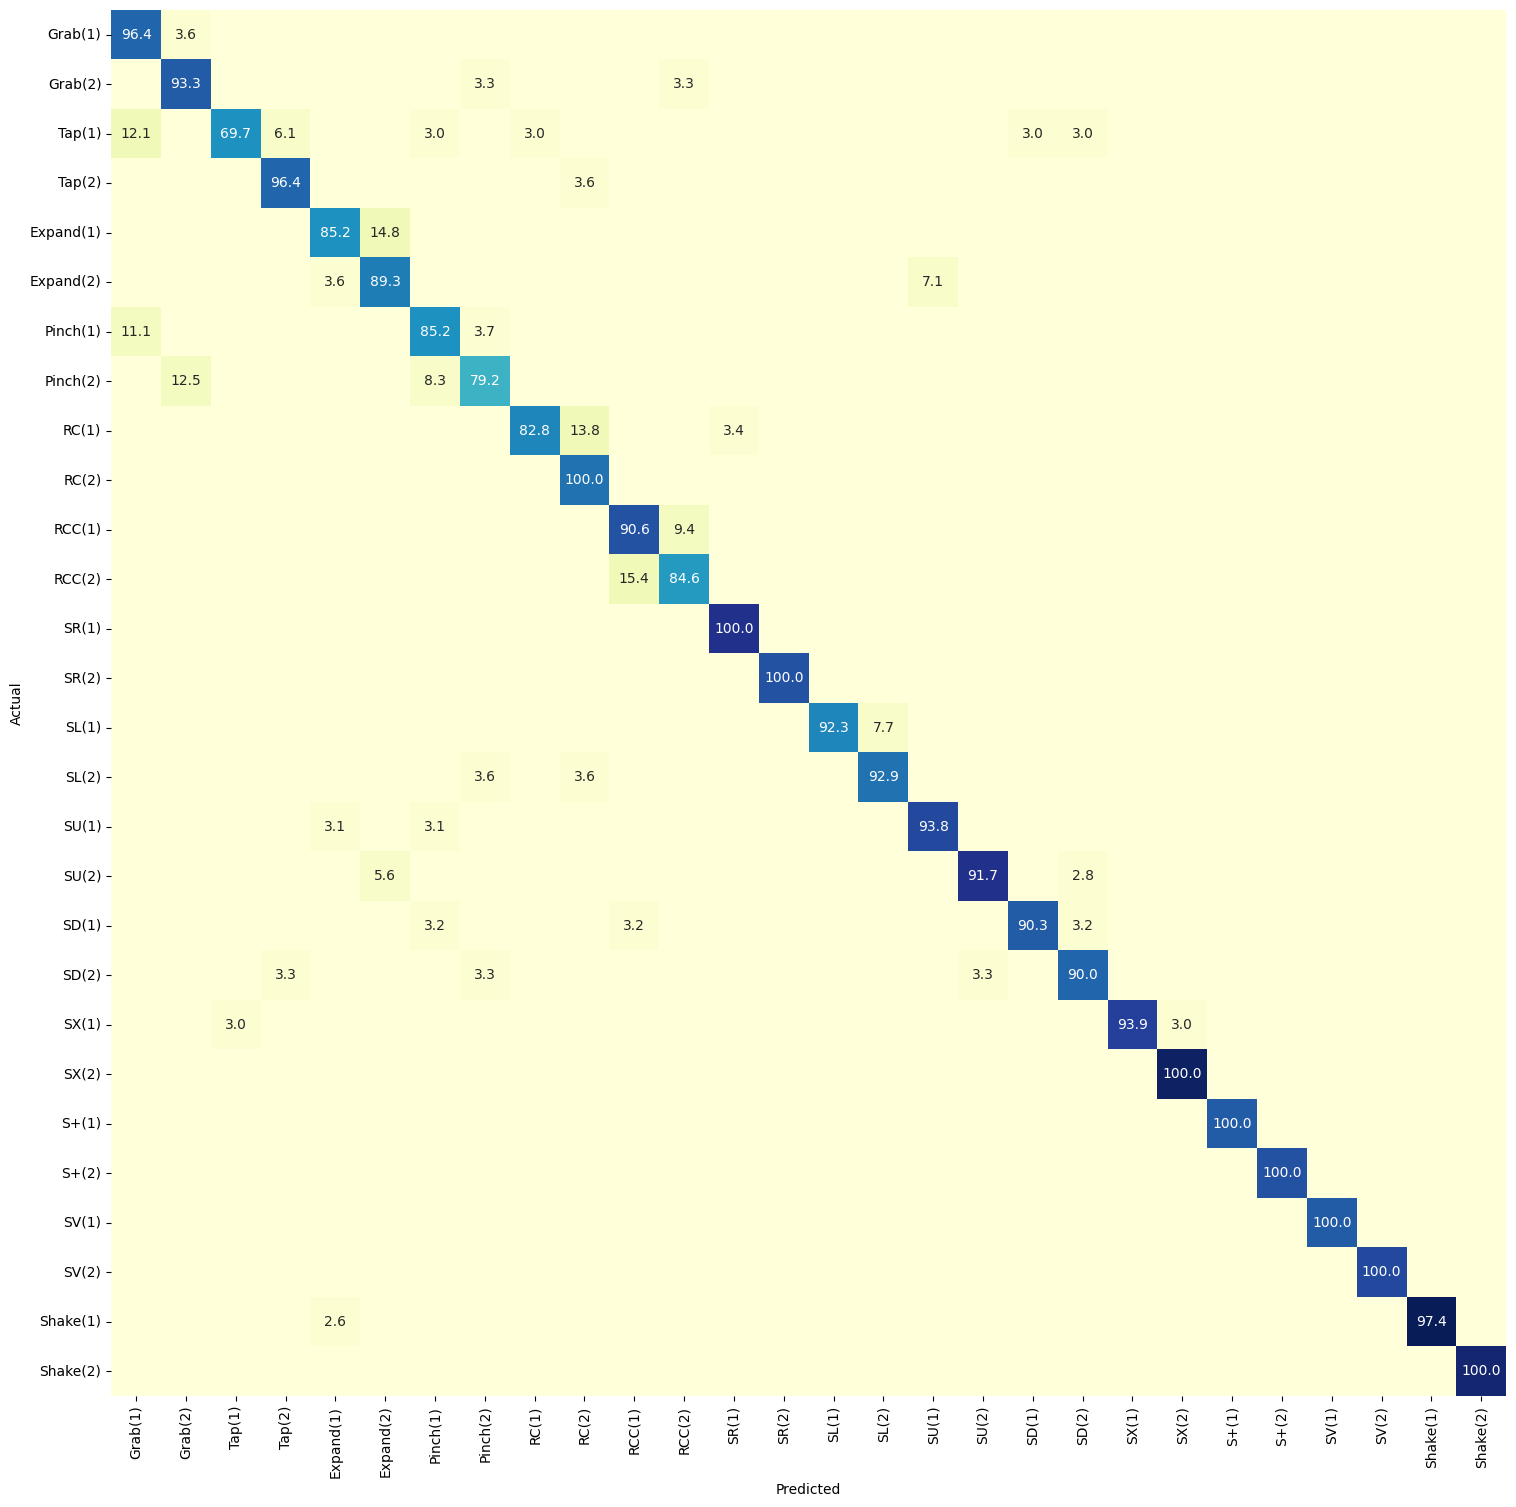

In [46]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_6.png', labels, ymap=None, figsize=(18,18))

### epoch 4

In [47]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:02<20:44,  1.50it/s]


 10%|███▉                                    | 192/1960 [02:06<18:50,  1.56it/s]


 15%|█████▉                                  | 289/1960 [03:08<17:51,  1.56it/s]


 20%|███████▉                                | 386/1960 [04:09<16:37,  1.58it/s]


 25%|█████████▊                              | 483/1960 [05:11<17:05,  1.44it/s]


 30%|███████████▊                            | 580/1960 [06:21<16:43,  1.38it/s]


 35%|█████████████▊                          | 677/1960 [07:32<15:36,  1.37it/s]


 39%|███████████████▊                        | 774/1960 [08:42<14:25,  1.37it/s]


 44%|█████████████████▊                      | 871/1960 [09:53<13:09,  1.38it/s]


 49%|███████████████████▊                    | 968/1960 [11:04<12:05,  1.37it/s]


 54%|█████████████████████▏                 | 1065/1960 [12:15<10:53,  1.37it/s]


 59%|███████████████████████                | 1162/1960 [13:26<09:36,  1.38it/s]


 64%|█████████████████████████              | 1259/1960 [14:37<08:48,  1.33it/s]


 69%|██████████████████████████▉            | 1356/1960 [15:48<07:03,  1.43it/s]


 74%|████████████████████████████▉          | 1453/1960 [16:58<06:12,  1.36it/s]


 79%|██████████████████████████████▊        | 1550/1960 [18:09<04:55,  1.39it/s]


 84%|████████████████████████████████▊      | 1647/1960 [19:19<03:44,  1.39it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [20:30<02:40,  1.34it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [21:40<01:26,  1.38it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [22:51<00:16,  1.34it/s]


100%|███████████████████████████████████████████| 1/1 [23:07<00:00, 1387.95s/it]


tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3541, -0.3207,  0.4625],
          [ 0.3312, -0.3412,  0.4597],
          ...,
          [ 0.3985, -0.2904,  0.4601],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3538, -0.3207,  0.4611],
          [ 0.3312, -0.3412,  0.4590],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         ...,

         [[ 0.2730, -0.2446,  0.3057],
          [ 0.2552, -0.1916,  0.2921],
          [ 0.2421, -0.2243,  0.2908],
          ...,
          [ 0.3004, -0.1702,  0.2906],
          [ 0.2907, -0.1831,  0.2805],
          [ 0.2882, -0

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 130.10it/s]


In [48]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0175 - accuracy: 0.9990 - val_loss: 0.4766 - val_accuracy: 0.9226
Epoch 2/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0486 - accuracy: 0.9898 - val_loss: 0.4313 - val_accuracy: 0.9131
Epoch 3/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0411 - accuracy: 0.9944 - val_loss: 0.4803 - val_accuracy: 0.9060
Epoch 4/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0518 - accuracy: 0.9883 - val_loss: 0.5737 - val_accuracy: 0.9000
Epoch 5/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0358 - accuracy: 0.9923 - val_loss: 0.6217 - val_accuracy: 0.8881
Epoch 6/600
1960/1960 [==============================] - 0s 152us/step - loss: 0.0491 - accuracy: 0.9898 - val_loss: 0.5774 - val_accuracy: 0.8929
Epoch 7/600
1960/1960 [==============================] - 0s 140us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0168 - accuracy: 0.9980 - val_loss: 0.4024 - val_accuracy: 0.9333
Epoch 58/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0168 - accuracy: 0.9990 - val_loss: 0.4022 - val_accuracy: 0.9333
Epoch 59/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0151 - accuracy: 0.9985 - val_loss: 0.4019 - val_accuracy: 0.9345
Epoch 60/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0189 - accuracy: 0.9974 - val_loss: 0.4023 - val_accuracy: 0.9345
Epoch 61/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0162 - accuracy: 0.9990 - val_loss: 0.4028 - val_accuracy: 0.9345
Epoch 62/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.4029 - val_accuracy: 0.9345
Epoch 63/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0152 - accuracy: 0.9995 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.3988 - val_accuracy: 0.9369
Epoch 114/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0163 - accuracy: 0.9980 - val_loss: 0.3988 - val_accuracy: 0.9369
Epoch 115/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0139 - accuracy: 0.9985 - val_loss: 0.3987 - val_accuracy: 0.9369
Epoch 116/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0187 - accuracy: 0.9974 - val_loss: 0.3986 - val_accuracy: 0.9369
Epoch 117/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.3985 - val_accuracy: 0.9369
Epoch 118/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0157 - accuracy: 0.9980 - val_loss: 0.3984 - val_accuracy: 0.9369
Epoch 119/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0149 - accuracy: 0.9995

Epoch 168/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 0.3957 - val_accuracy: 0.9357
Epoch 169/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0183 - accuracy: 0.9980 - val_loss: 0.3957 - val_accuracy: 0.9357
Epoch 170/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.3956 - val_accuracy: 0.9357
Epoch 171/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0141 - accuracy: 0.9990 - val_loss: 0.3957 - val_accuracy: 0.9357
Epoch 172/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0165 - accuracy: 0.9974 - val_loss: 0.3957 - val_accuracy: 0.9357
Epoch 173/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0144 - accuracy: 0.9990 - val_loss: 0.3958 - val_accuracy: 0.9357
Epoch 174/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0151 - accuracy: 0.9990

Epoch 223/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0144 - accuracy: 0.9990 - val_loss: 0.3974 - val_accuracy: 0.9345
Epoch 224/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 0.3973 - val_accuracy: 0.9345
Epoch 225/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.3972 - val_accuracy: 0.9345
Epoch 226/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0146 - accuracy: 0.9995 - val_loss: 0.3970 - val_accuracy: 0.9345
Epoch 227/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0147 - accuracy: 0.9990 - val_loss: 0.3968 - val_accuracy: 0.9345
Epoch 228/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0159 - accuracy: 0.9990 - val_loss: 0.3967 - val_accuracy: 0.9345
Epoch 229/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0141 - accuracy: 0.9985

Epoch 278/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0135 - accuracy: 0.9990 - val_loss: 0.3973 - val_accuracy: 0.9345
Epoch 279/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0195 - accuracy: 0.9980 - val_loss: 0.3971 - val_accuracy: 0.9345
Epoch 280/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0194 - accuracy: 0.9985 - val_loss: 0.3970 - val_accuracy: 0.9345
Epoch 281/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0122 - accuracy: 0.9985 - val_loss: 0.3970 - val_accuracy: 0.9345
Epoch 282/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.3969 - val_accuracy: 0.9345
Epoch 283/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0141 - accuracy: 0.9990 - val_loss: 0.3970 - val_accuracy: 0.9345
Epoch 284/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0161 - accuracy: 0.9980

Epoch 333/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.4019 - val_accuracy: 0.9345
Epoch 334/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0190 - accuracy: 0.9980 - val_loss: 0.4018 - val_accuracy: 0.9345
Epoch 335/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0143 - accuracy: 0.9995 - val_loss: 0.4018 - val_accuracy: 0.9345
Epoch 336/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 0.4018 - val_accuracy: 0.9345
Epoch 337/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0138 - accuracy: 0.9985 - val_loss: 0.4018 - val_accuracy: 0.9345
Epoch 338/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0154 - accuracy: 0.9990 - val_loss: 0.4017 - val_accuracy: 0.9345
Epoch 339/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0125 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0139 - accuracy: 0.9990 - val_loss: 0.4005 - val_accuracy: 0.9357
Epoch 389/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0129 - accuracy: 0.9995 - val_loss: 0.4003 - val_accuracy: 0.9357
Epoch 390/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0141 - accuracy: 0.9985 - val_loss: 0.4001 - val_accuracy: 0.9357
Epoch 391/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0206 - accuracy: 0.9980 - val_loss: 0.3999 - val_accuracy: 0.9357
Epoch 392/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0156 - accuracy: 0.9980 - val_loss: 0.3997 - val_accuracy: 0.9357
Epoch 393/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.3995 - val_accuracy: 0.9357
Epoch 394/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0128 - accuracy: 0.9990

Epoch 443/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0136 - accuracy: 0.9980 - val_loss: 0.4000 - val_accuracy: 0.9345
Epoch 444/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0161 - accuracy: 0.9990 - val_loss: 0.4001 - val_accuracy: 0.9345
Epoch 445/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0133 - accuracy: 0.9985 - val_loss: 0.4002 - val_accuracy: 0.9345
Epoch 446/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0128 - accuracy: 0.9990 - val_loss: 0.4002 - val_accuracy: 0.9345
Epoch 447/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0169 - accuracy: 0.9980 - val_loss: 0.4002 - val_accuracy: 0.9345
Epoch 448/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0182 - accuracy: 0.9985 - val_loss: 0.4005 - val_accuracy: 0.9345
Epoch 449/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0148 - accuracy: 0.9985

Epoch 498/600
1960/1960 [==============================] - 0s 151us/step - loss: 0.0121 - accuracy: 0.9995 - val_loss: 0.3999 - val_accuracy: 0.9357
Epoch 499/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0149 - accuracy: 0.9985 - val_loss: 0.3999 - val_accuracy: 0.9357
Epoch 500/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.4000 - val_accuracy: 0.9357
Epoch 501/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0138 - accuracy: 0.9985 - val_loss: 0.4001 - val_accuracy: 0.9357
Epoch 502/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0152 - accuracy: 0.9980 - val_loss: 0.4003 - val_accuracy: 0.9357
Epoch 503/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0131 - accuracy: 0.9995 - val_loss: 0.4005 - val_accuracy: 0.9357
Epoch 504/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0158 - accuracy: 0.9985

Epoch 553/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0128 - accuracy: 0.9995 - val_loss: 0.4022 - val_accuracy: 0.9357
Epoch 554/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0123 - accuracy: 0.9995 - val_loss: 0.4020 - val_accuracy: 0.9357
Epoch 555/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.4019 - val_accuracy: 0.9357
Epoch 556/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0144 - accuracy: 0.9995 - val_loss: 0.4018 - val_accuracy: 0.9357
Epoch 557/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.4017 - val_accuracy: 0.9357
Epoch 558/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0152 - accuracy: 0.9995 - val_loss: 0.4016 - val_accuracy: 0.9357
Epoch 559/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0141 - accuracy: 0.9985

In [49]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9357142857142857


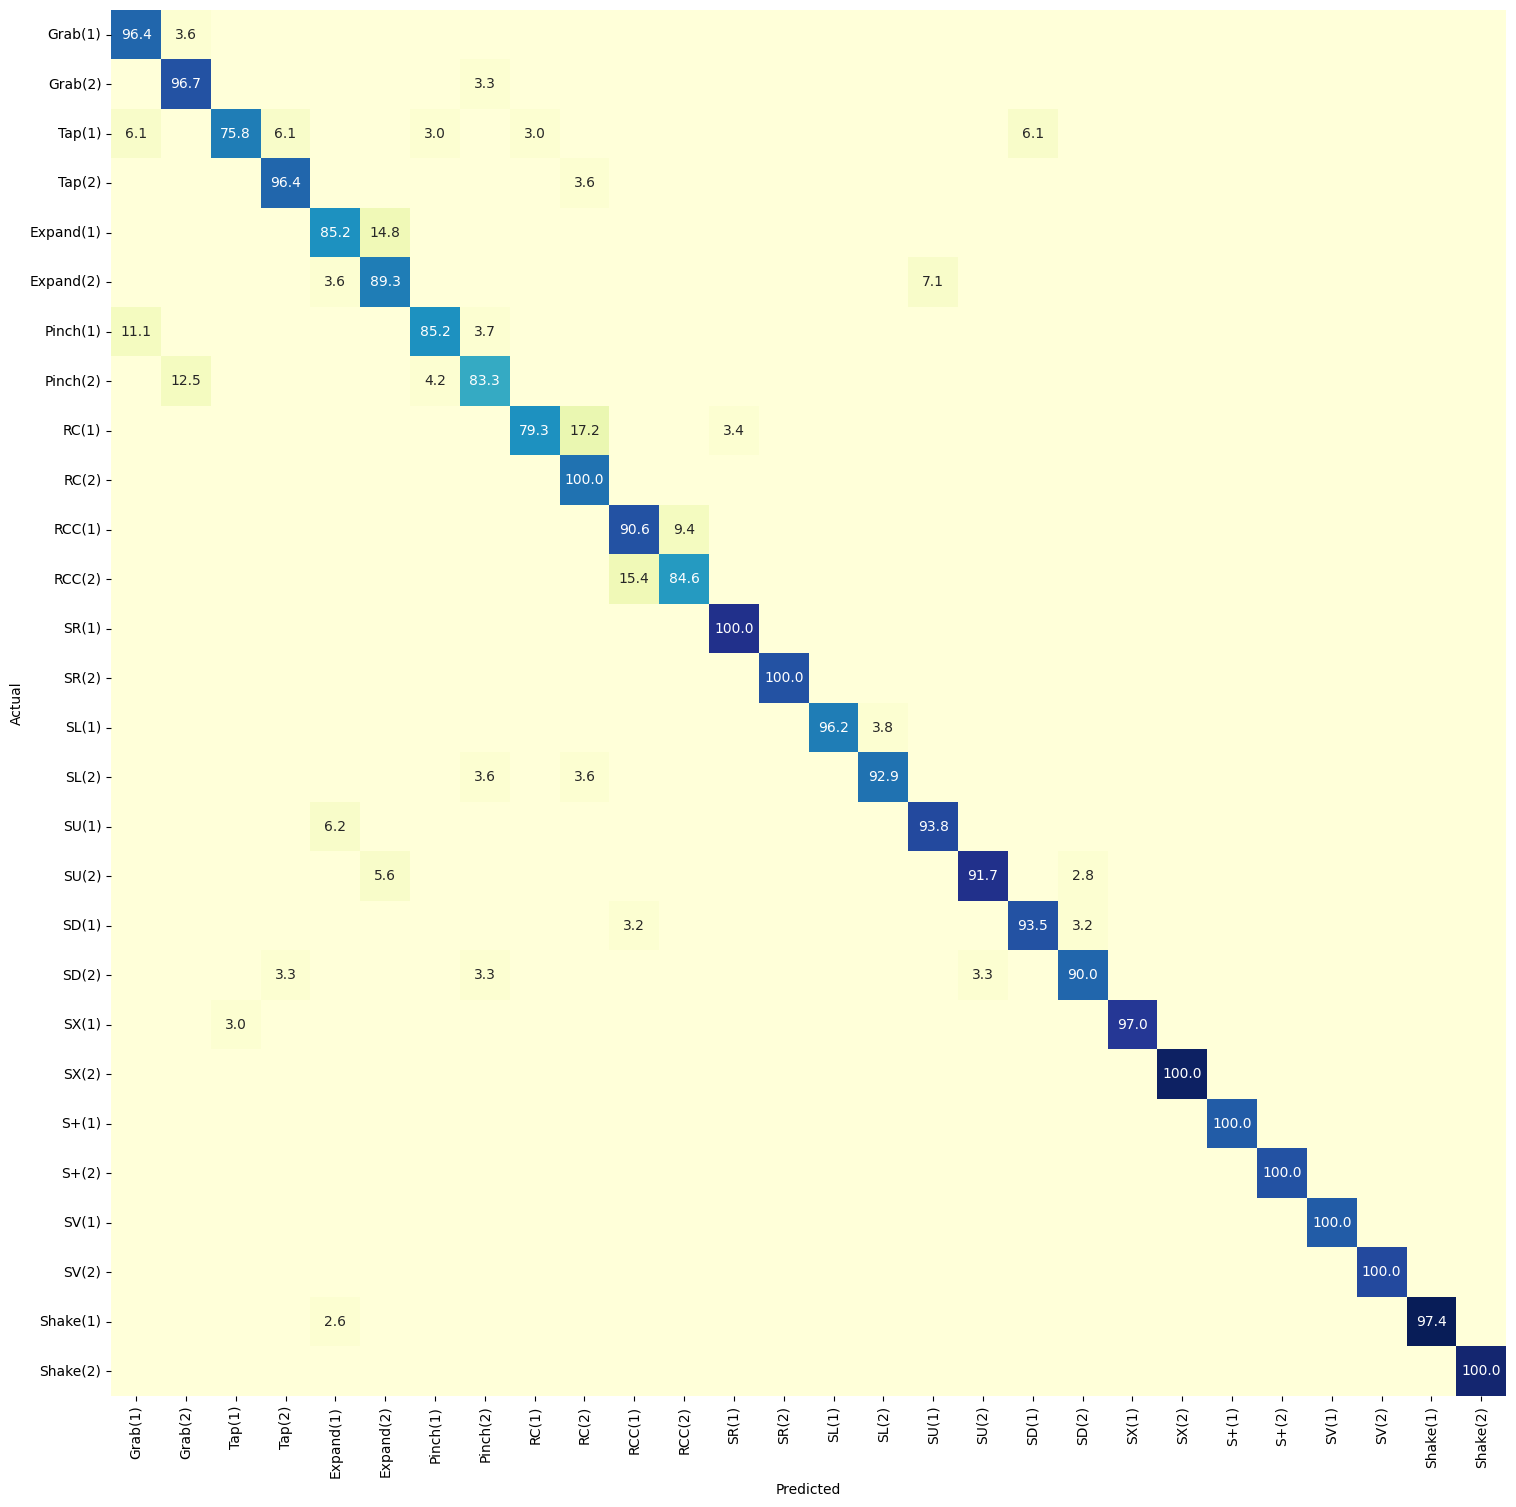

In [50]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_7.png', labels, ymap=None, figsize=(18,18))

### epoch 5

In [51]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:05<23:05,  1.35it/s]


 10%|███▉                                    | 192/1960 [02:18<22:05,  1.33it/s]


 15%|█████▉                                  | 289/1960 [03:31<20:39,  1.35it/s]


 20%|███████▉                                | 386/1960 [04:43<19:46,  1.33it/s]


 25%|█████████▊                              | 483/1960 [05:55<18:15,  1.35it/s]


 30%|███████████▊                            | 580/1960 [07:09<17:35,  1.31it/s]


 35%|█████████████▊                          | 677/1960 [08:22<15:57,  1.34it/s]


 39%|███████████████▊                        | 774/1960 [09:35<14:44,  1.34it/s]


 44%|█████████████████▊                      | 871/1960 [10:49<13:44,  1.32it/s]


 49%|███████████████████▊                    | 968/1960 [12:01<12:36,  1.31it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:14<10:59,  1.36it/s]


 59%|███████████████████████                | 1162/1960 [14:27<09:57,  1.33it/s]


 64%|█████████████████████████              | 1259/1960 [15:40<08:45,  1.33it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:53<07:34,  1.33it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:06<06:25,  1.31it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:20<05:14,  1.30it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:33<03:57,  1.32it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:46<02:43,  1.32it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:59<01:30,  1.31it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:11<00:16,  1.33it/s]


100%|███████████████████████████████████████████| 1/1 [24:27<00:00, 1467.96s/it]


tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3541, -0.3207,  0.4625],
          [ 0.3312, -0.3412,  0.4597],
          ...,
          [ 0.3985, -0.2904,  0.4601],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         [[ 0.3560, -0.3637,  0.4684],
          [ 0.3538, -0.3207,  0.4611],
          [ 0.3312, -0.3412,  0.4590],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3973, -0.2811,  0.4523],
          [ 0.4096, -0.2958,  0.4594]],

         ...,

         [[ 0.2730, -0.2446,  0.3057],
          [ 0.2552, -0.1916,  0.2921],
          [ 0.2421, -0.2243,  0.2908],
          ...,
          [ 0.3004, -0.1702,  0.2906],
          [ 0.2907, -0.1831,  0.2805],
          [ 0.2882, -0

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 128.69it/s]


In [52]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0126 - accuracy: 0.9990 - val_loss: 0.5360 - val_accuracy: 0.9107
Epoch 2/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0400 - accuracy: 0.9929 - val_loss: 0.6452 - val_accuracy: 0.8952
Epoch 3/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0349 - accuracy: 0.9929 - val_loss: 0.5414 - val_accuracy: 0.9107
Epoch 4/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0488 - accuracy: 0.9878 - val_loss: 0.4587 - val_accuracy: 0.9143
Epoch 5/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0409 - accuracy: 0.9898 - val_loss: 0.4501 - val_accuracy: 0.9214
Epoch 6/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0352 - accuracy: 0.9939 - val_loss: 0.5064 - val_accuracy: 0.9095
Epoch 7/600
1960/1960 [==============================] - 0s 130us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0137 - accuracy: 0.9985 - val_loss: 0.4393 - val_accuracy: 0.9333
Epoch 58/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0123 - accuracy: 0.9985 - val_loss: 0.4394 - val_accuracy: 0.9333
Epoch 59/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0150 - accuracy: 0.9985 - val_loss: 0.4394 - val_accuracy: 0.9333
Epoch 60/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.4394 - val_accuracy: 0.9321
Epoch 61/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 0.4394 - val_accuracy: 0.9321
Epoch 62/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0148 - accuracy: 0.9995 - val_loss: 0.4393 - val_accuracy: 0.9321
Epoch 63/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0124 - accuracy: 0.9995 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0148 - accuracy: 0.9974 - val_loss: 0.4294 - val_accuracy: 0.9321
Epoch 114/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0142 - accuracy: 0.9990 - val_loss: 0.4294 - val_accuracy: 0.9321
Epoch 115/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 0.4294 - val_accuracy: 0.9321
Epoch 116/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0115 - accuracy: 0.9995 - val_loss: 0.4295 - val_accuracy: 0.9321
Epoch 117/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0115 - accuracy: 0.9985 - val_loss: 0.4295 - val_accuracy: 0.9321
Epoch 118/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 0.4295 - val_accuracy: 0.9321
Epoch 119/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0124 - accuracy: 0.9995

Epoch 168/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0133 - accuracy: 0.9985 - val_loss: 0.4220 - val_accuracy: 0.9357
Epoch 169/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0122 - accuracy: 0.9995 - val_loss: 0.4220 - val_accuracy: 0.9357
Epoch 170/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.4219 - val_accuracy: 0.9357
Epoch 171/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0131 - accuracy: 0.9990 - val_loss: 0.4218 - val_accuracy: 0.9357
Epoch 172/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 0.4217 - val_accuracy: 0.9357
Epoch 173/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0117 - accuracy: 0.9985 - val_loss: 0.4216 - val_accuracy: 0.9357
Epoch 174/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0156 - accuracy: 0.9964

Epoch 223/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.4190 - val_accuracy: 0.9357
Epoch 224/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0112 - accuracy: 0.9995 - val_loss: 0.4189 - val_accuracy: 0.9357
Epoch 225/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0122 - accuracy: 0.9990 - val_loss: 0.4187 - val_accuracy: 0.9357
Epoch 226/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0122 - accuracy: 0.9995 - val_loss: 0.4185 - val_accuracy: 0.9357
Epoch 227/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0144 - accuracy: 0.9985 - val_loss: 0.4183 - val_accuracy: 0.9357
Epoch 228/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 0.4182 - val_accuracy: 0.9357
Epoch 229/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0125 - accuracy: 0.9990

Epoch 278/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0121 - accuracy: 0.9995 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 279/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0147 - accuracy: 0.9985 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 280/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 281/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0107 - accuracy: 0.9995 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 282/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 283/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0135 - accuracy: 0.9990 - val_loss: 0.4179 - val_accuracy: 0.9369
Epoch 284/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0131 - accuracy: 0.9990

Epoch 333/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.4175 - val_accuracy: 0.9369
Epoch 334/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0142 - accuracy: 0.9990 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 335/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0147 - accuracy: 0.9985 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 336/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0114 - accuracy: 0.9990 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 337/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.4173 - val_accuracy: 0.9369
Epoch 338/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0128 - accuracy: 0.9990 - val_loss: 0.4173 - val_accuracy: 0.9369
Epoch 339/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0118 - accuracy: 0.9990

Epoch 388/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.4181 - val_accuracy: 0.9381
Epoch 389/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0118 - accuracy: 0.9995 - val_loss: 0.4180 - val_accuracy: 0.9381
Epoch 390/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0102 - accuracy: 0.9995 - val_loss: 0.4180 - val_accuracy: 0.9381
Epoch 391/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 0.4178 - val_accuracy: 0.9381
Epoch 392/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.4177 - val_accuracy: 0.9381
Epoch 393/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.4175 - val_accuracy: 0.9381
Epoch 394/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0103 - accuracy: 0.9995

Epoch 443/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.4166 - val_accuracy: 0.9381
Epoch 444/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0119 - accuracy: 0.9985 - val_loss: 0.4165 - val_accuracy: 0.9381
Epoch 445/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0115 - accuracy: 0.9990 - val_loss: 0.4163 - val_accuracy: 0.9381
Epoch 446/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.4162 - val_accuracy: 0.9381
Epoch 447/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.4160 - val_accuracy: 0.9381
Epoch 448/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.4159 - val_accuracy: 0.9381
Epoch 449/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0114 - accuracy: 0.9990

Epoch 498/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.4166 - val_accuracy: 0.9369
Epoch 499/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0120 - accuracy: 0.9990 - val_loss: 0.4167 - val_accuracy: 0.9369
Epoch 500/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0139 - accuracy: 0.9990 - val_loss: 0.4167 - val_accuracy: 0.9369
Epoch 501/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.4168 - val_accuracy: 0.9369
Epoch 502/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.4169 - val_accuracy: 0.9369
Epoch 503/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0122 - accuracy: 0.9990 - val_loss: 0.4170 - val_accuracy: 0.9369
Epoch 504/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0129 - accuracy: 0.9985

Epoch 553/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.4176 - val_accuracy: 0.9369
Epoch 554/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0099 - accuracy: 0.9995 - val_loss: 0.4175 - val_accuracy: 0.9369
Epoch 555/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 556/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 557/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0133 - accuracy: 0.9995 - val_loss: 0.4174 - val_accuracy: 0.9369
Epoch 558/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0102 - accuracy: 0.9990 - val_loss: 0.4175 - val_accuracy: 0.9369
Epoch 559/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0114 - accuracy: 0.9990

In [53]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9380952380952381


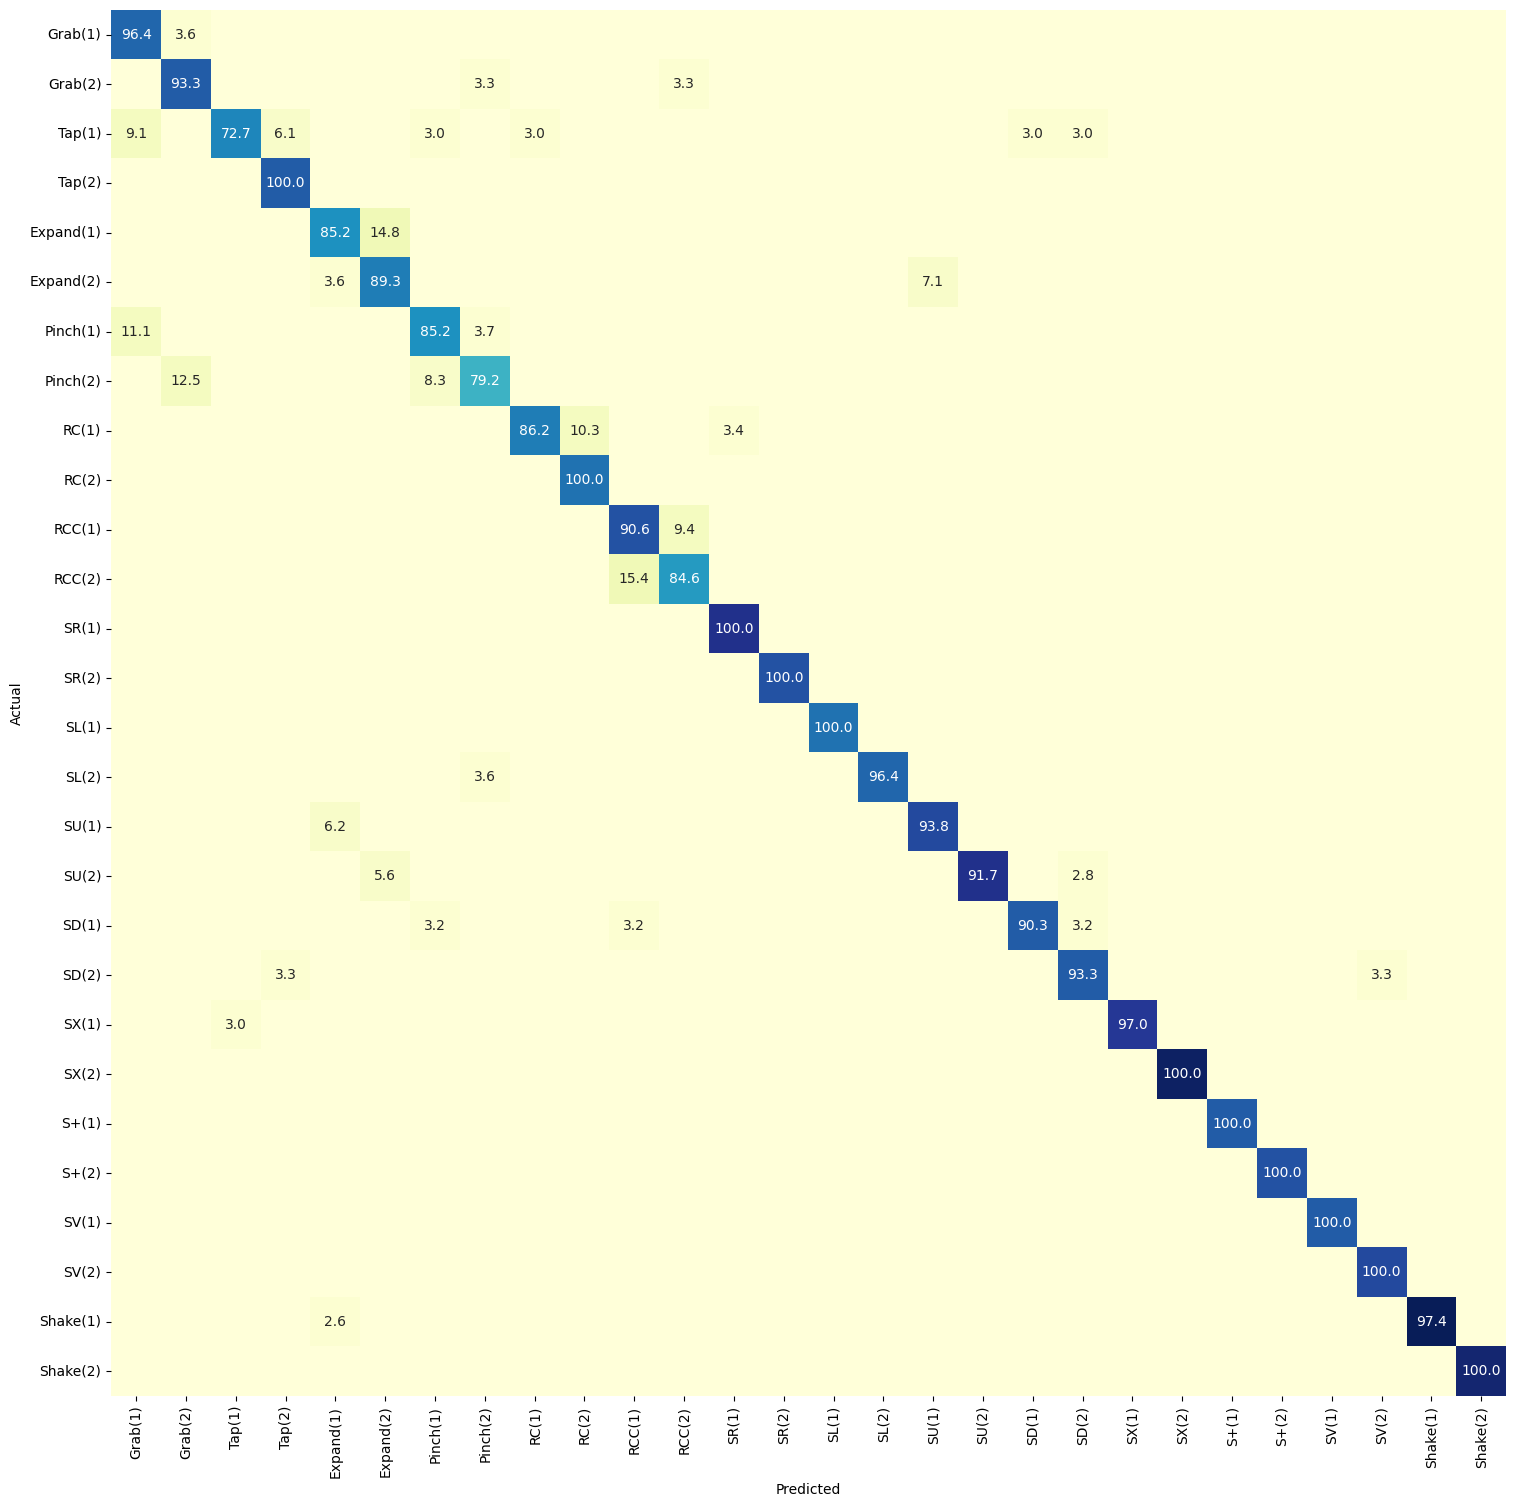

In [54]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_8.png', labels, ymap=None, figsize=(18,18))